<a href="https://colab.research.google.com/github/iamharkirat/Machine-Learning-Projects/blob/main/music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!apt-get update -qq
!apt-get install -qq musescore

Extracting templates from packages: 100%
Selecting previously unselected package libqt5core5a:amd64.
(Reading database ... 120875 files and directories currently installed.)
Preparing to unpack .../00-libqt5core5a_5.15.3+dfsg-2ubuntu0.2_amd64.deb ...
Unpacking libqt5core5a:amd64 (5.15.3+dfsg-2ubuntu0.2) ...
Selecting previously unselected package libevdev2:amd64.
Preparing to unpack .../01-libevdev2_1.12.1+dfsg-1_amd64.deb ...
Unpacking libevdev2:amd64 (1.12.1+dfsg-1) ...
Selecting previously unselected package libmtdev1:amd64.
Preparing to unpack .../02-libmtdev1_1.1.6-1build4_amd64.deb ...
Unpacking libmtdev1:amd64 (1.1.6-1build4) ...
Selecting previously unselected package libgudev-1.0-0:amd64.
Preparing to unpack .../03-libgudev-1.0-0_1%3a237-2build1_amd64.deb ...
Unpacking libgudev-1.0-0:amd64 (1:237-2build1) ...
Selecting previously unselected package libwacom-common.
Preparing to unpack .../04-libwacom-common_2.2.0-1_all.deb ...
Unpacking libwacom-common (2.2.0-1) ...
Selecting 

In [27]:
from music21 import environment
us = environment.UserSettings()
us['musicxmlPath'] = '/usr/bin/musescore'
us['musescoreDirectPNGPath'] = '/usr/bin/musescore'


In [28]:
import os
from music21 import converter, instrument, note, chord
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Bidirectional, Dropout, Dense,
                                     Activation, BatchNormalization, Attention,
                                     Concatenate)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import numpy as np


In [40]:
def parse_midi(folder_path, num_songs_to_parse=None):
    notes = []
    num_songs = 0  # Counter for songs

    for file in os.listdir(folder_path):
        # Check if file is a MIDI file
        if not file.endswith(".mid"):
            continue

        # If a maximum number of songs to parse is specified, and we've reached that number, exit the loop
        if num_songs_to_parse is not None and num_songs >= num_songs_to_parse:
            break

        midi = converter.parse(os.path.join(folder_path, file))
        notes_to_parse = None
        parts = instrument.partitionByInstrument(midi)

        if parts:
            notes_to_parse = parts.parts[0].recurse()
        else:
            notes_to_parse = midi.flat.notes

        song_notes = []
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                song_notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                song_notes.append('.'.join(str(n) for n in element.normalOrder))

        # If some notes were parsed, increment the song counter
        if len(song_notes) > 0:
            num_songs += 1
            notes += song_notes
            print(f"{num_songs} songs parsed, {len(song_notes)} notes and chords parsed from {file}")
            print(f"Total notes and chords so far: {len(notes)}")

    return notes

def prepare_sequences(notes, n_vocab):
    sequence_length = 100
    pitchnames = sorted(set(item for item in notes))
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    network_input = []
    network_output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    n_patterns = len(network_input)
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = network_input / float(n_vocab)
    network_output = to_categorical(network_output)  # Adjusted usage
    return network_input, network_output


In [41]:
def create_model(network_input, n_vocab):
    """Create the structure of the neural network"""
    input_layer = Input(shape=(network_input.shape[1], network_input.shape[2]))

    # Bidirectional LSTMs
    lstm1 = Bidirectional(LSTM(512, return_sequences=True))(input_layer)
    dropout1 = Dropout(0.3)(lstm1)

    lstm2 = Bidirectional(LSTM(512, return_sequences=True))(dropout1)
    dropout2 = Dropout(0.3)(lstm2)

    lstm3 = LSTM(512, return_sequences=True)(dropout2)

    # Attention Mechanism
    attention = Attention(use_scale=True)([lstm3, lstm3])

    # Merge output of Attention layer with LSTM layer
    merged = Concatenate(axis=-1)([lstm3, attention])

    # Additional LSTM layer with dropout
    lstm4 = LSTM(512)(merged)
    dropout4 = Dropout(0.3)(lstm4)

    dense1 = Dense(256)(dropout4)
    batch_norm1 = BatchNormalization()(dense1)
    activation1 = Activation('relu')(batch_norm1)
    dropout5 = Dropout(0.3)(activation1)

    output_layer = Dense(n_vocab, activation='softmax')(dropout5)

    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile model with the specified optimizer, loss, and metric
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

    return model


In [42]:
def lr_schedule(epoch, lr):
    if epoch > 100:
        return lr * 0.1
    elif epoch > 150:
        return lr * 0.01
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [43]:
def train_model(model, network_input, network_output, epochs=200):
    """Train the neural network"""

    # Define the learning rate scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Define ModelCheckpoint
    model_checkpoint = ModelCheckpoint(
        'best_model.h5', monitor='loss', verbose=1, save_best_only=True, mode='min'
    )

    # Train the model
    history = model.fit(
        network_input, network_output,
        epochs=epochs,
        callbacks=[lr_scheduler, model_checkpoint],
        batch_size=64,  # you might want to adjust the batch size
        validation_split=0.2  # consider using a validation split to monitor overfitting
    )

    return model, history

In [44]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    """Generate notes from the neural network based on a sequence of notes"""
    # Pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    pattern = network_input[start]
    prediction_output = []
    # Generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)
        prediction = model.predict(prediction_input, verbose=0)
        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        pattern = np.append(pattern, index)
        pattern = pattern[1:len(pattern)]
    return prediction_output

In [45]:
from music21 import stream

def create_midi(prediction_output, filename):
    """Convert the output from the prediction to notes and create a midi file from the notes"""
    offset = 0
    output_notes = []
    # Create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # Pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # Pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # Increase offset each iteration so that notes do not stack
        offset += 0.5
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)


In [46]:
folder_path = '/content/drive/MyDrive/bach_midi'


In [47]:
# Parse MIDI files
notes = parse_midi(folder_path, num_songs_to_parse=20)

1 songs parsed, 4993 notes and chords parsed from waldstein_3.mid
Total notes and chords so far: 4993
2 songs parsed, 186 notes and chords parsed from chpn_op35_2.mid
Total notes and chords so far: 5179


In [37]:
# Prepare sequences
n_vocab = len(set(notes))
network_input, network_output = prepare_sequences(notes, n_vocab)
print(network_input, '\n', network_output)

[[[0.7254902 ]
  [0.83006536]
  [0.97385621]
  ...
  [0.98039216]
  [0.74509804]
  [0.97385621]]

 [[0.83006536]
  [0.97385621]
  [0.73856209]
  ...
  [0.74509804]
  [0.97385621]
  [0.83660131]]

 [[0.97385621]
  [0.73856209]
  [0.83660131]
  ...
  [0.97385621]
  [0.83660131]
  [0.98039216]]

 ...

 [[0.64705882]
  [0.86928105]
  [0.80392157]
  ...
  [0.7124183 ]
  [0.86928105]
  [0.94117647]]

 [[0.86928105]
  [0.80392157]
  [0.94117647]
  ...
  [0.86928105]
  [0.94117647]
  [0.64705882]]

 [[0.80392157]
  [0.94117647]
  [0.64705882]
  ...
  [0.94117647]
  [0.64705882]
  [0.64705882]]] 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [38]:
# Create the model
model = create_model(network_input, n_vocab)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 1)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 100, 1024)            2105344   ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 dropout_3 (Dropout)         (None, 100, 1024)            0         ['bidirectional[0][0]']       
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 100, 1024)            6295552   ['dropout_3[0][0]']       

In [39]:
# Train the model
train_model(model, network_input, network_output, epochs=10)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 4.7399 - accuracy: 0.0490
Epoch 1: loss improved from inf to 4.73989, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 30s 274ms/step - loss: 4.7399 - accuracy: 0.0490 - val_loss: 5.6379 - val_accuracy: 0.0935 - lr: 0.0010
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 4.6278 - accuracy: 0.0445
Epoch 2: loss improved from 4.73989 to 4.62785, saving model to best_model.h5
64/64 [==============================] - 16s 245ms/step - loss: 4.6278 - accuracy: 0.0445 - val_loss: 5.4657 - val_accuracy: 0.0157 - lr: 0.0010
Epoch 3/10
41/64 [==================>...........] - ETA: 4s - loss: 4.3823 - accuracy: 0.0633

KeyboardInterrupt: ignored

In [ ]:
# Generate notes
prediction_output = generate_notes(model, network_input, sorted(set(notes)), n_vocab)

In [ ]:
# Convert generated notes to MIDI file
create_midi(prediction_output, 'generated_song.mid')

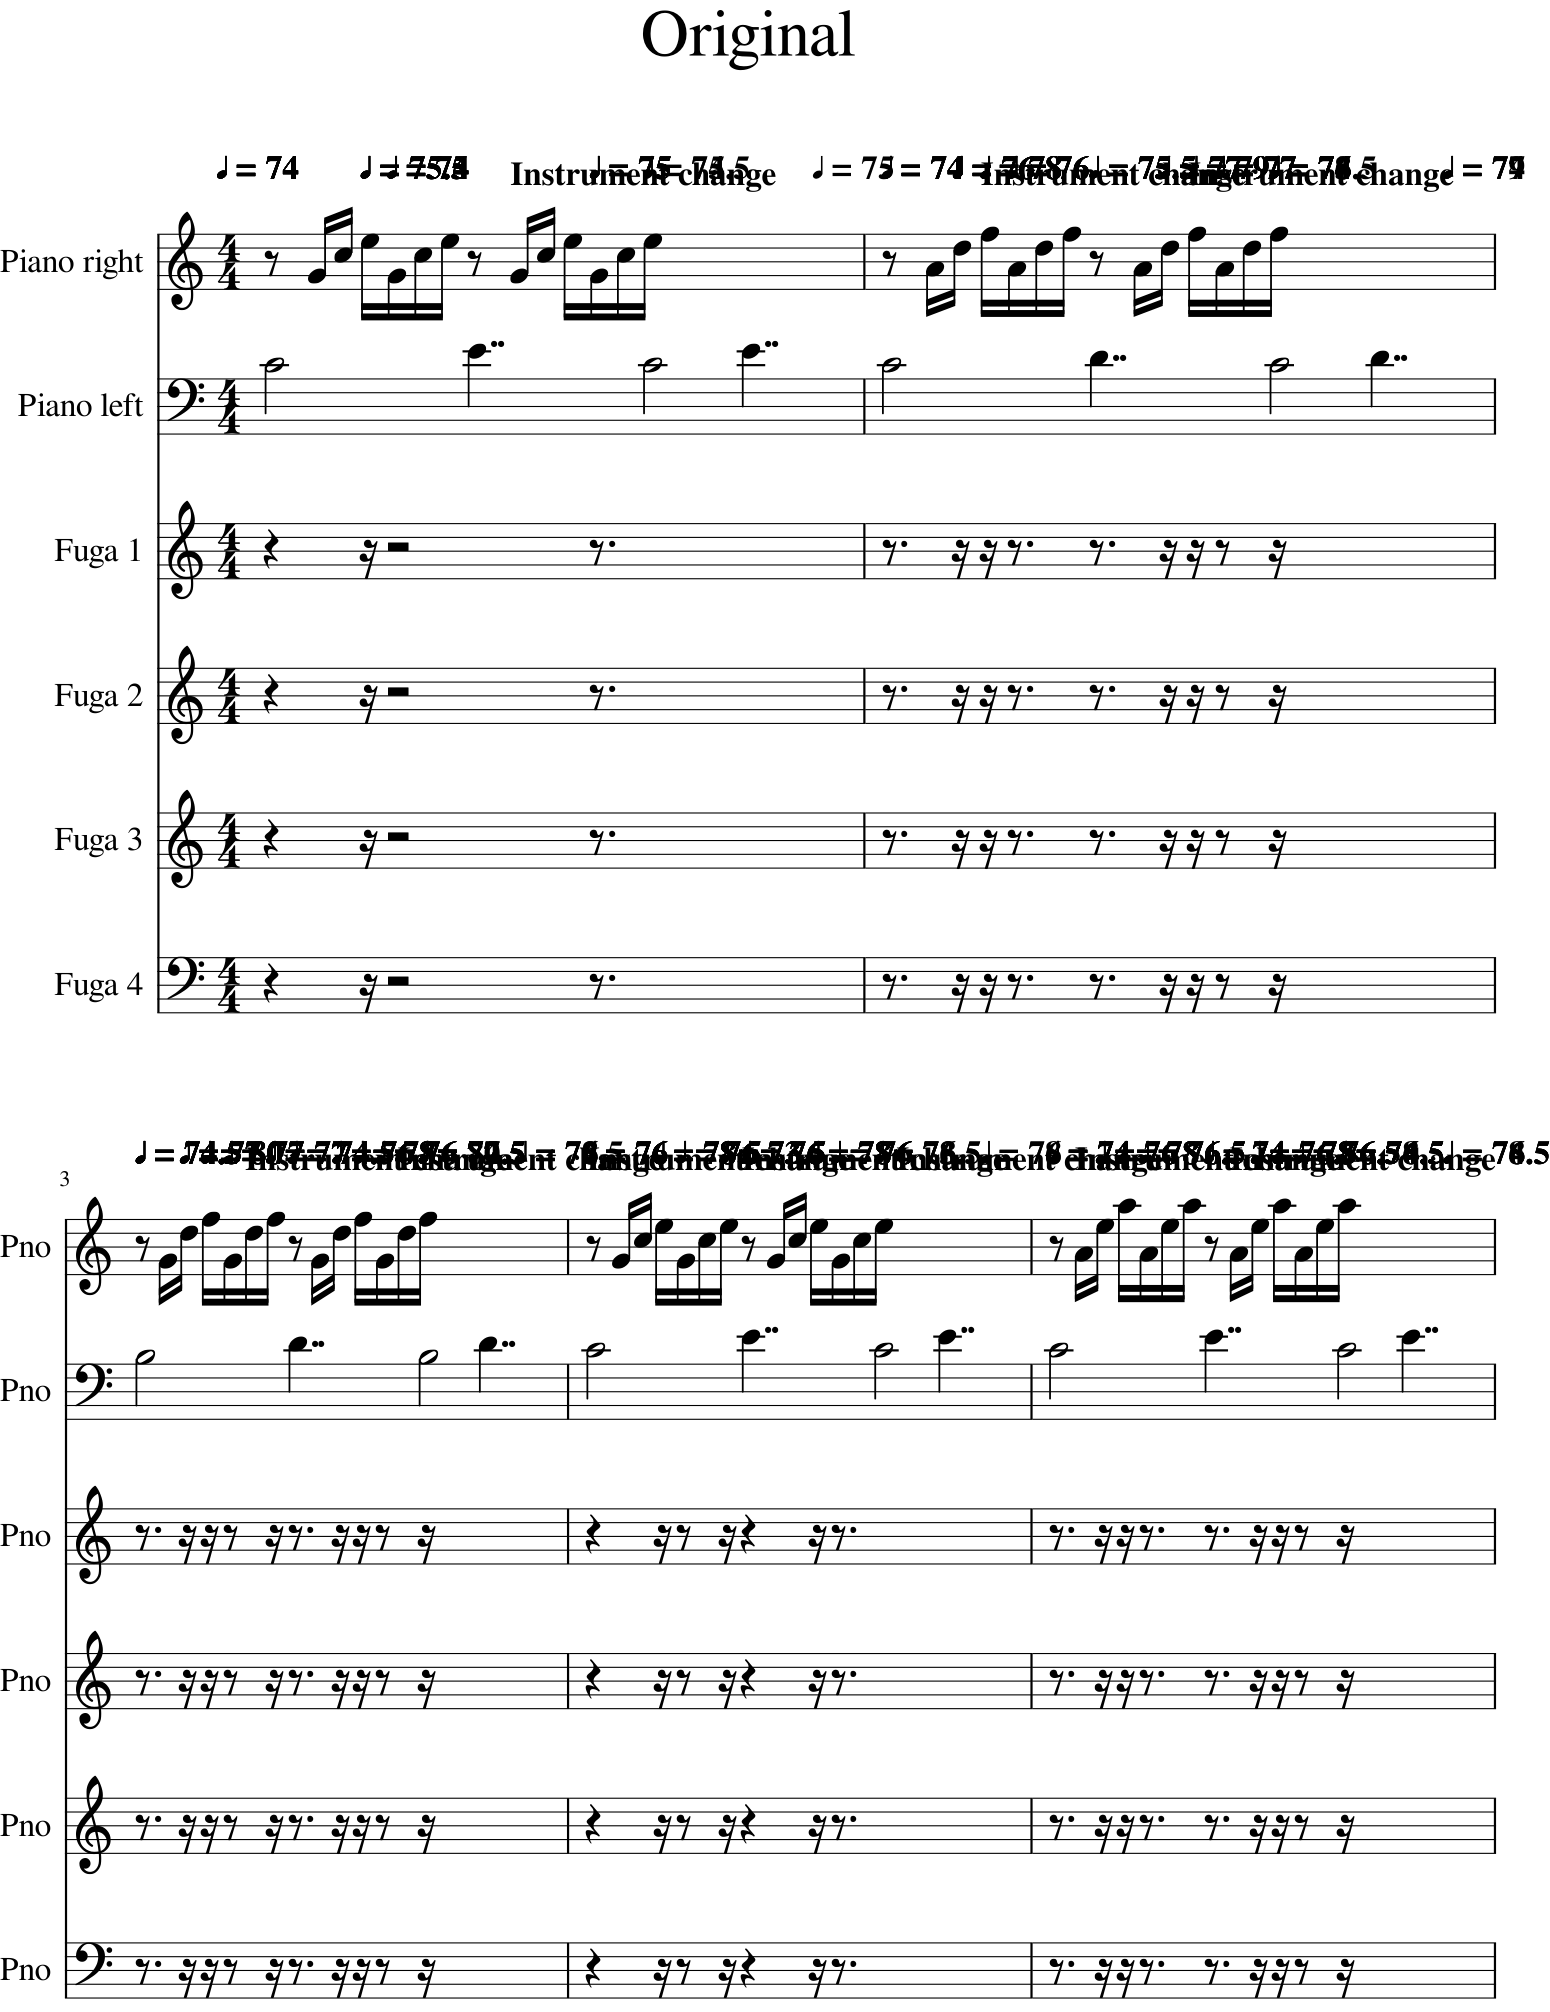

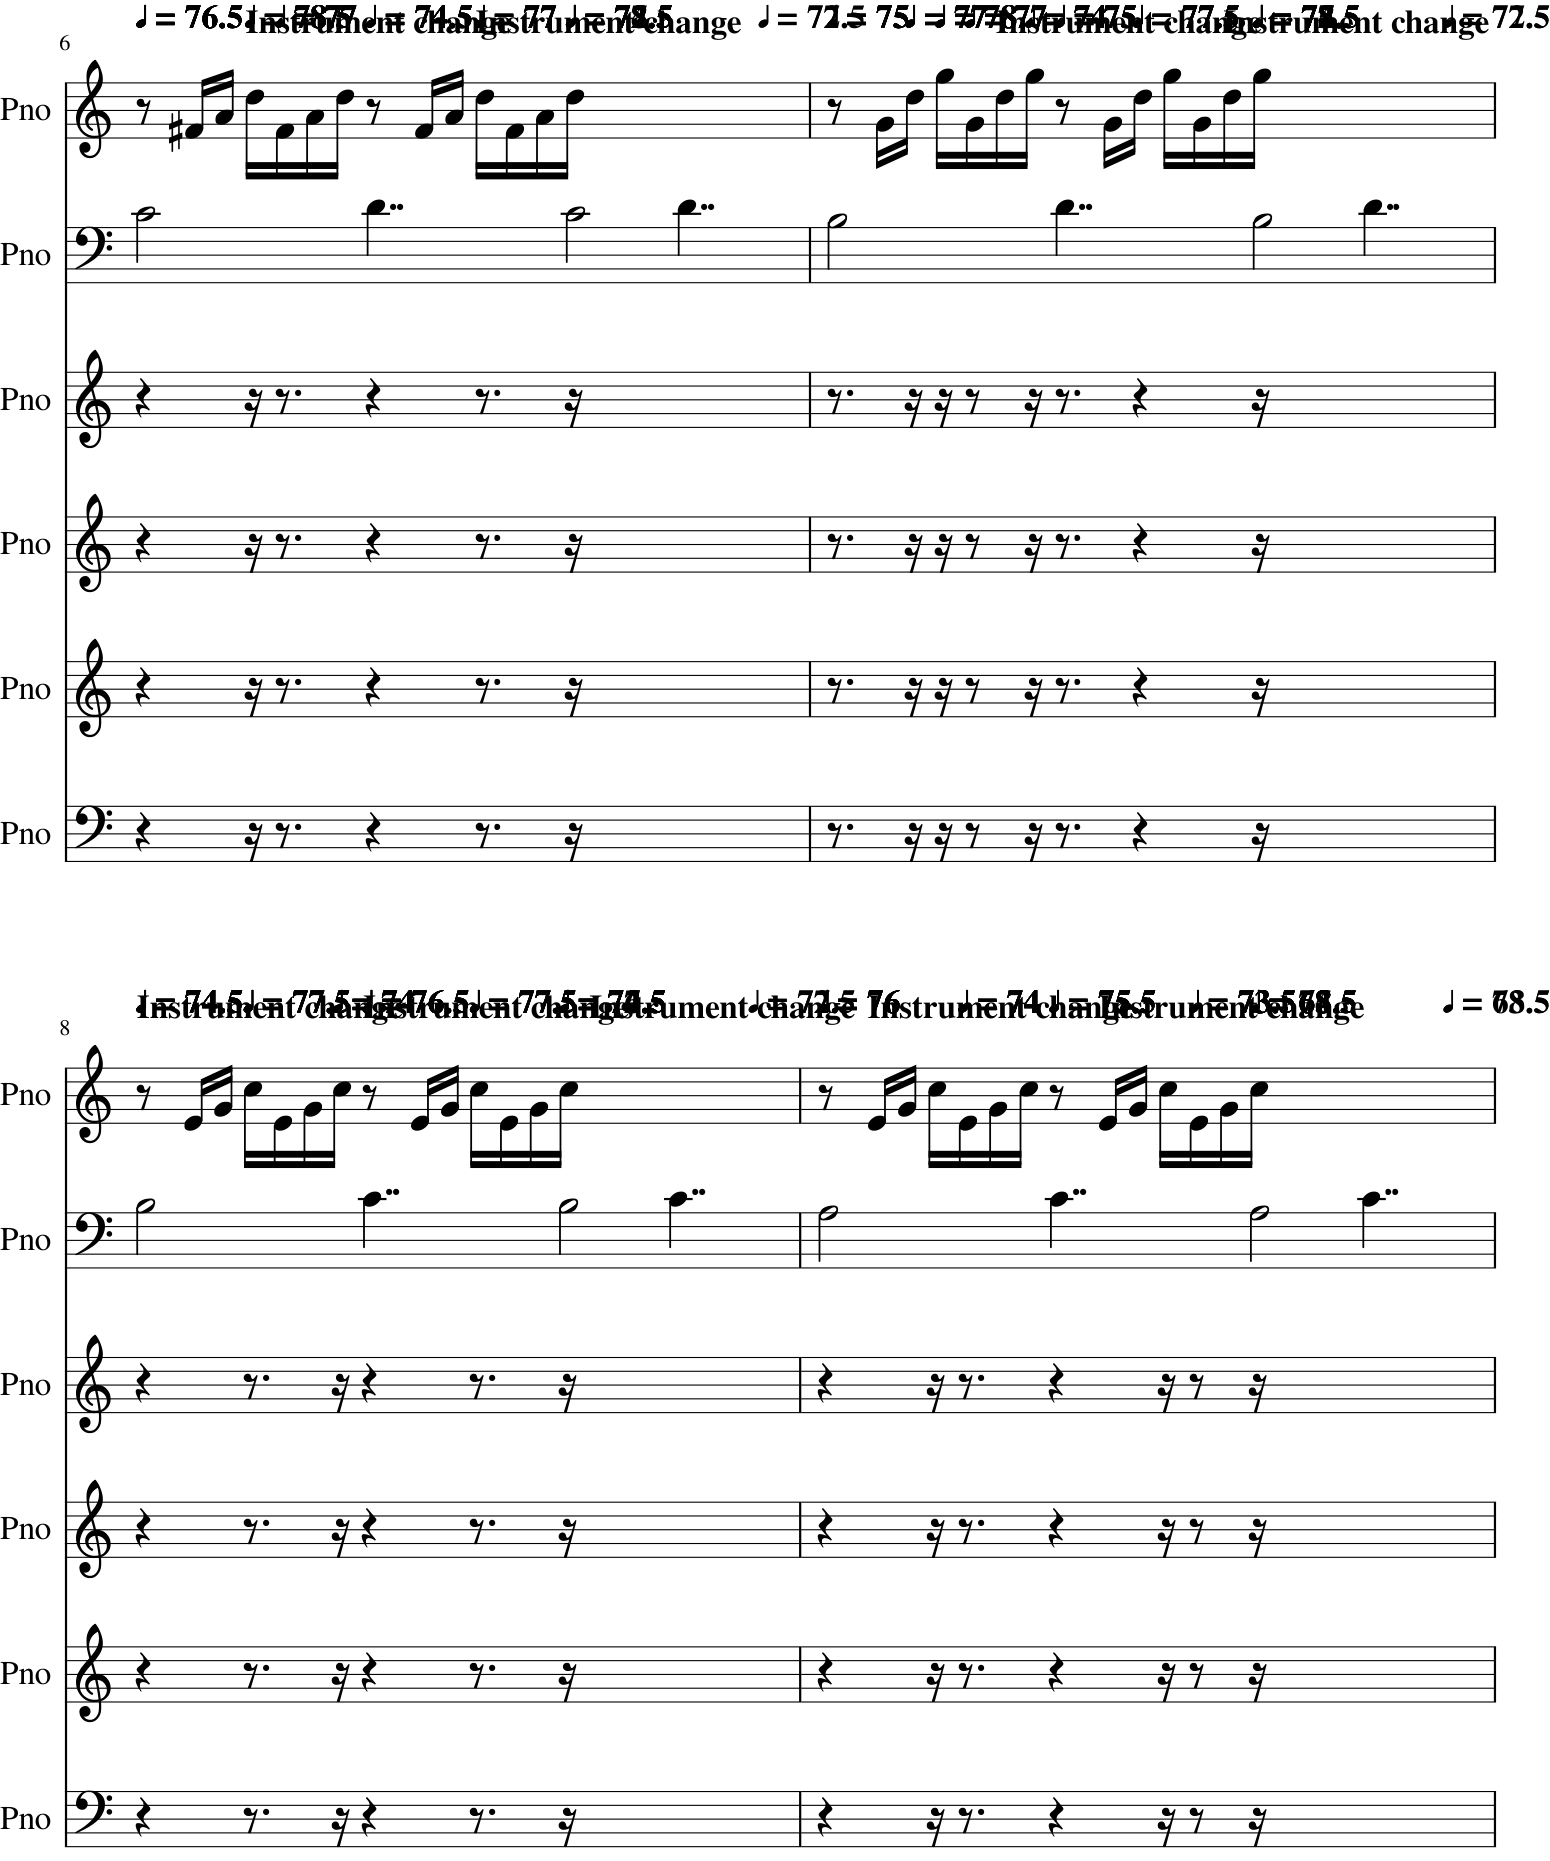

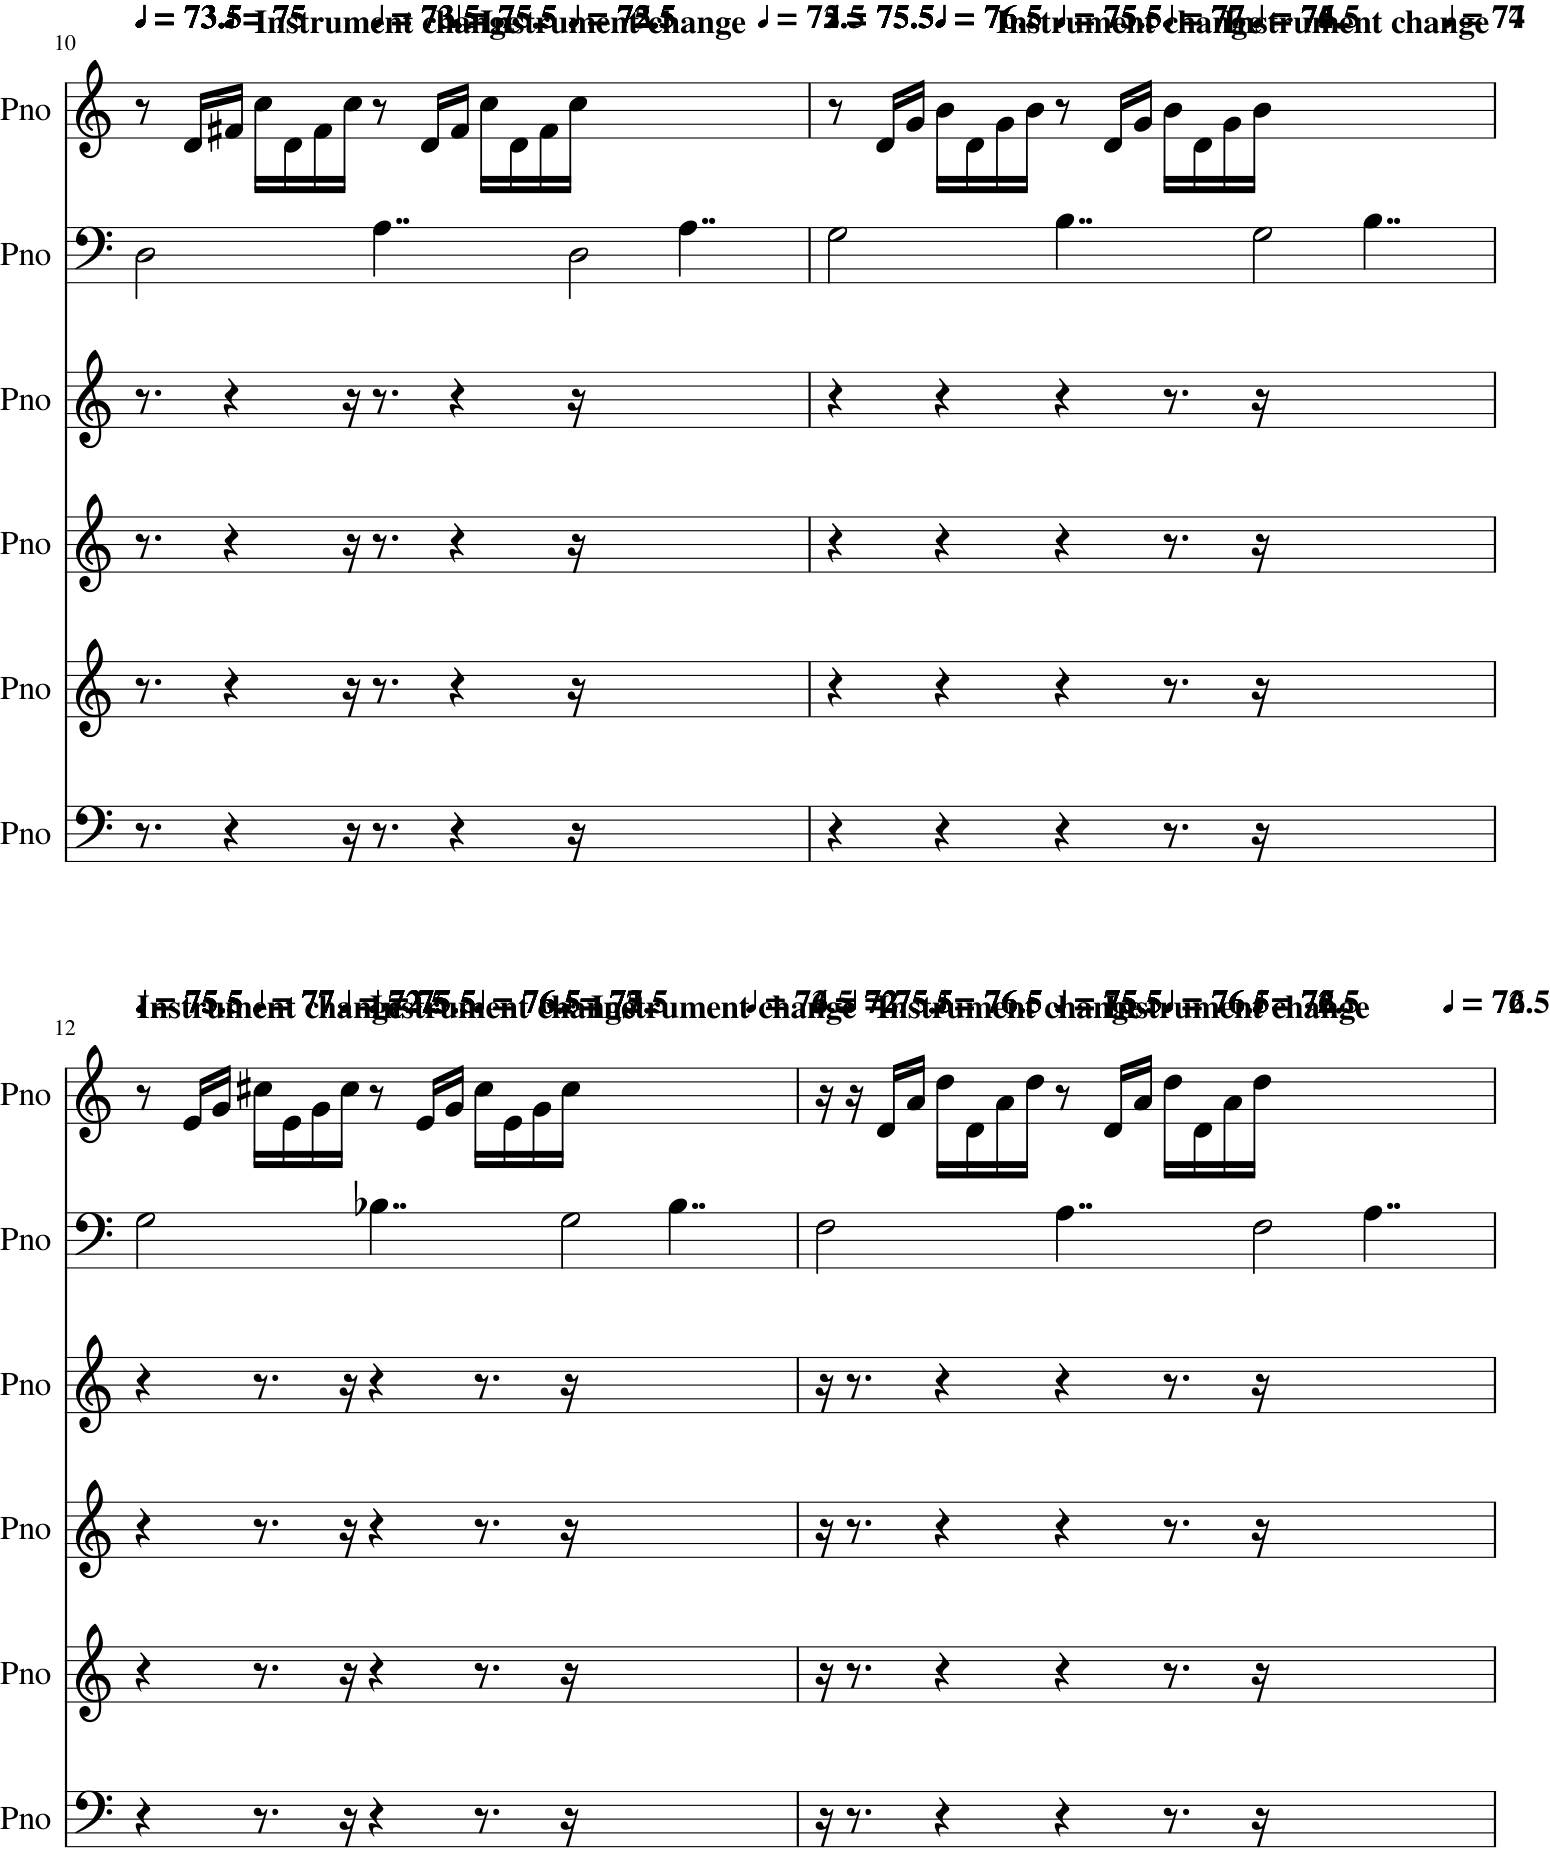

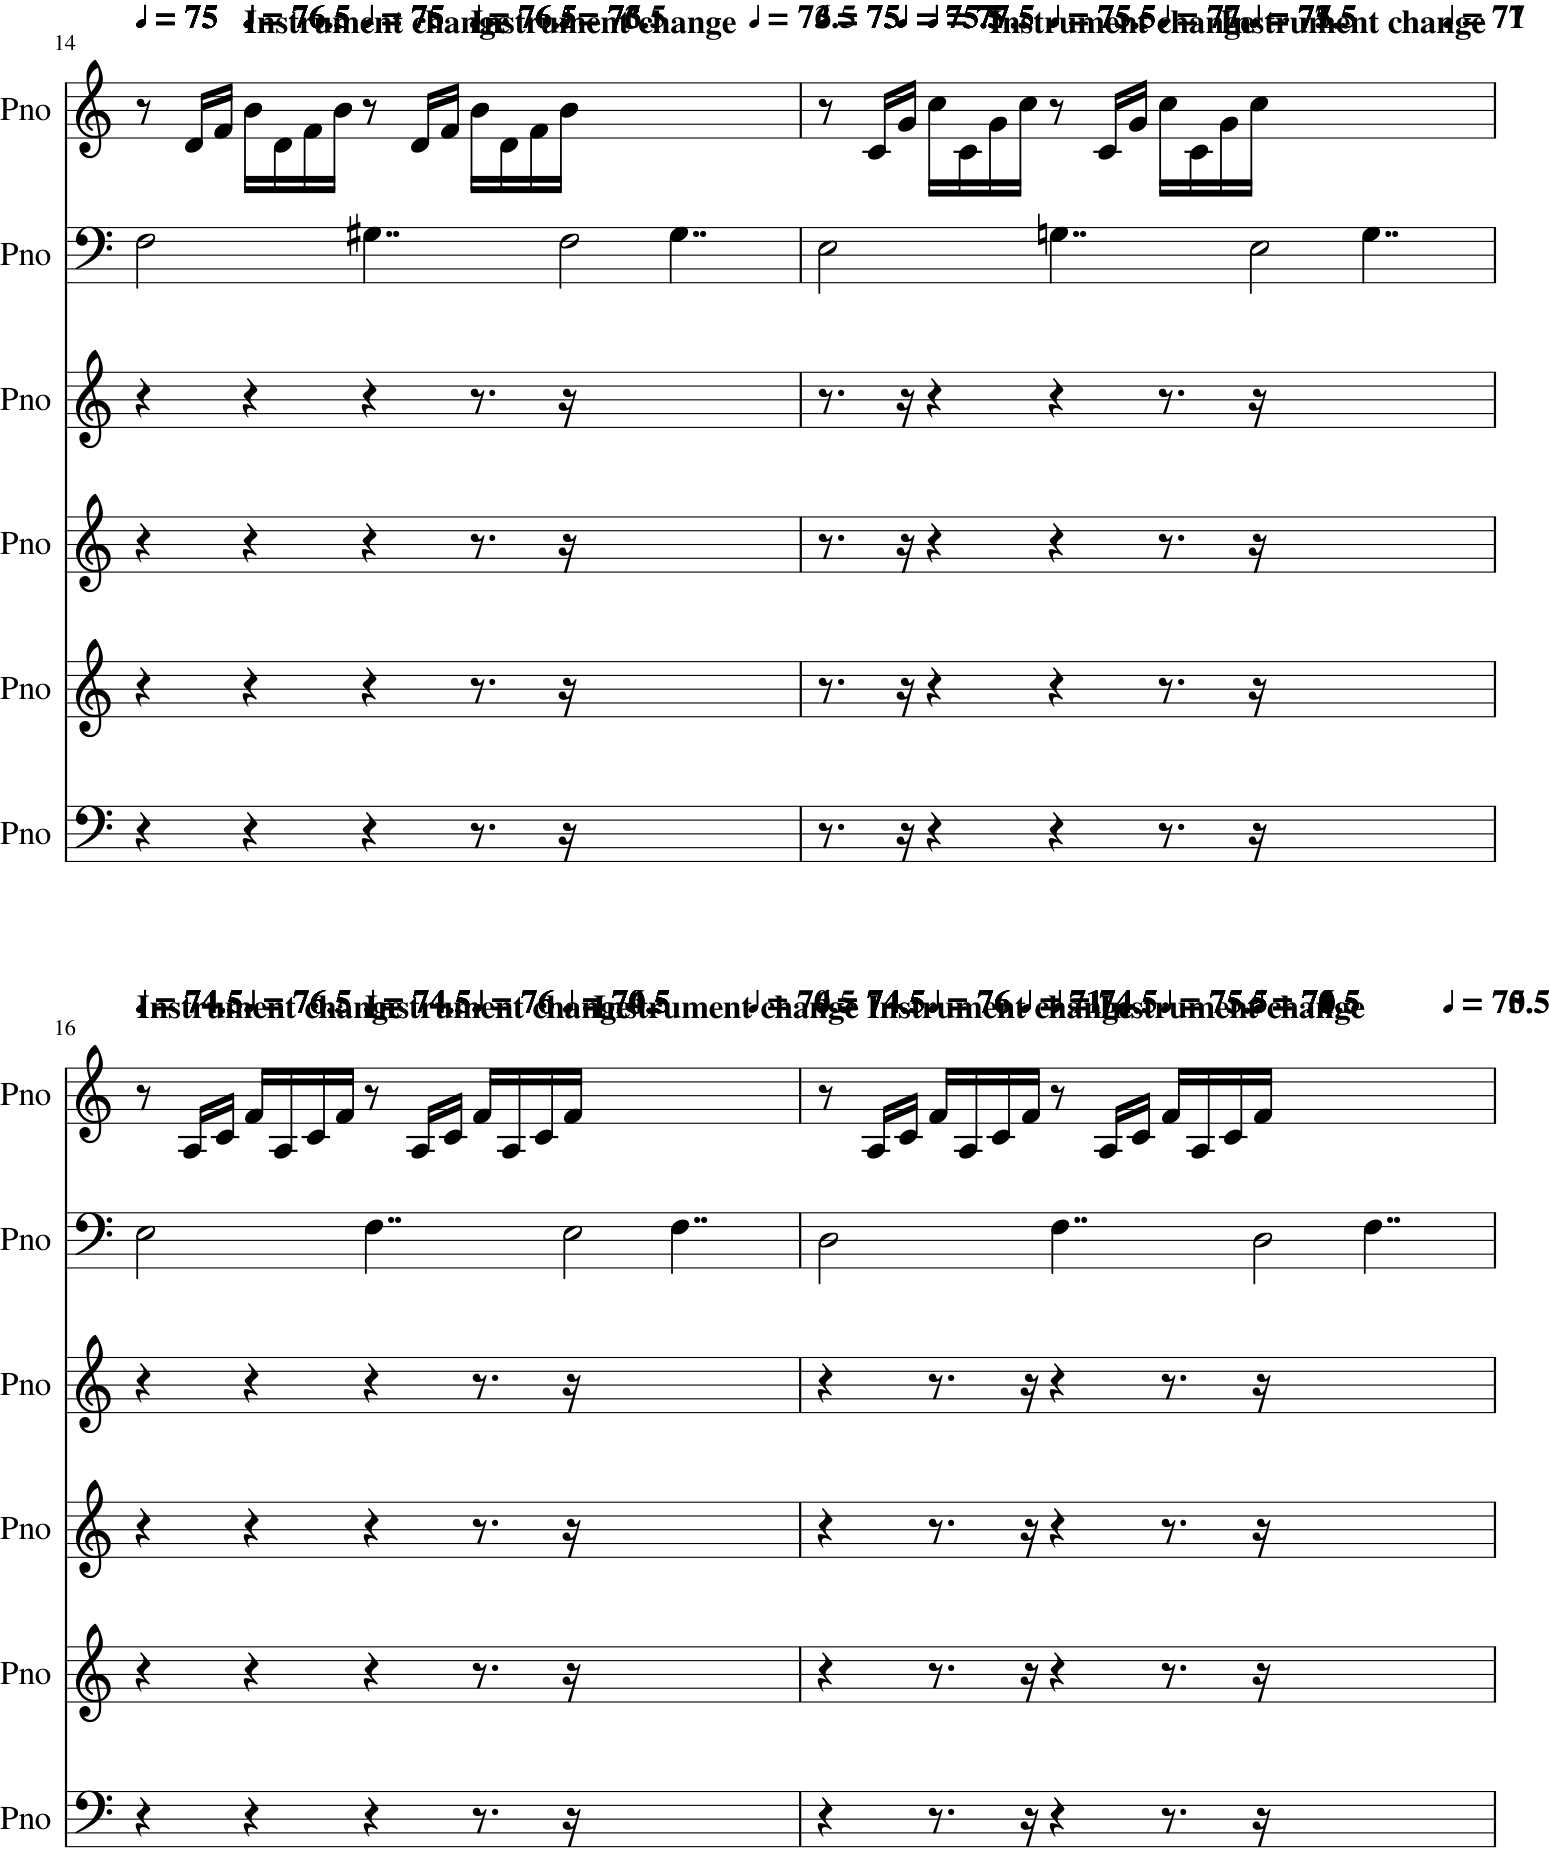

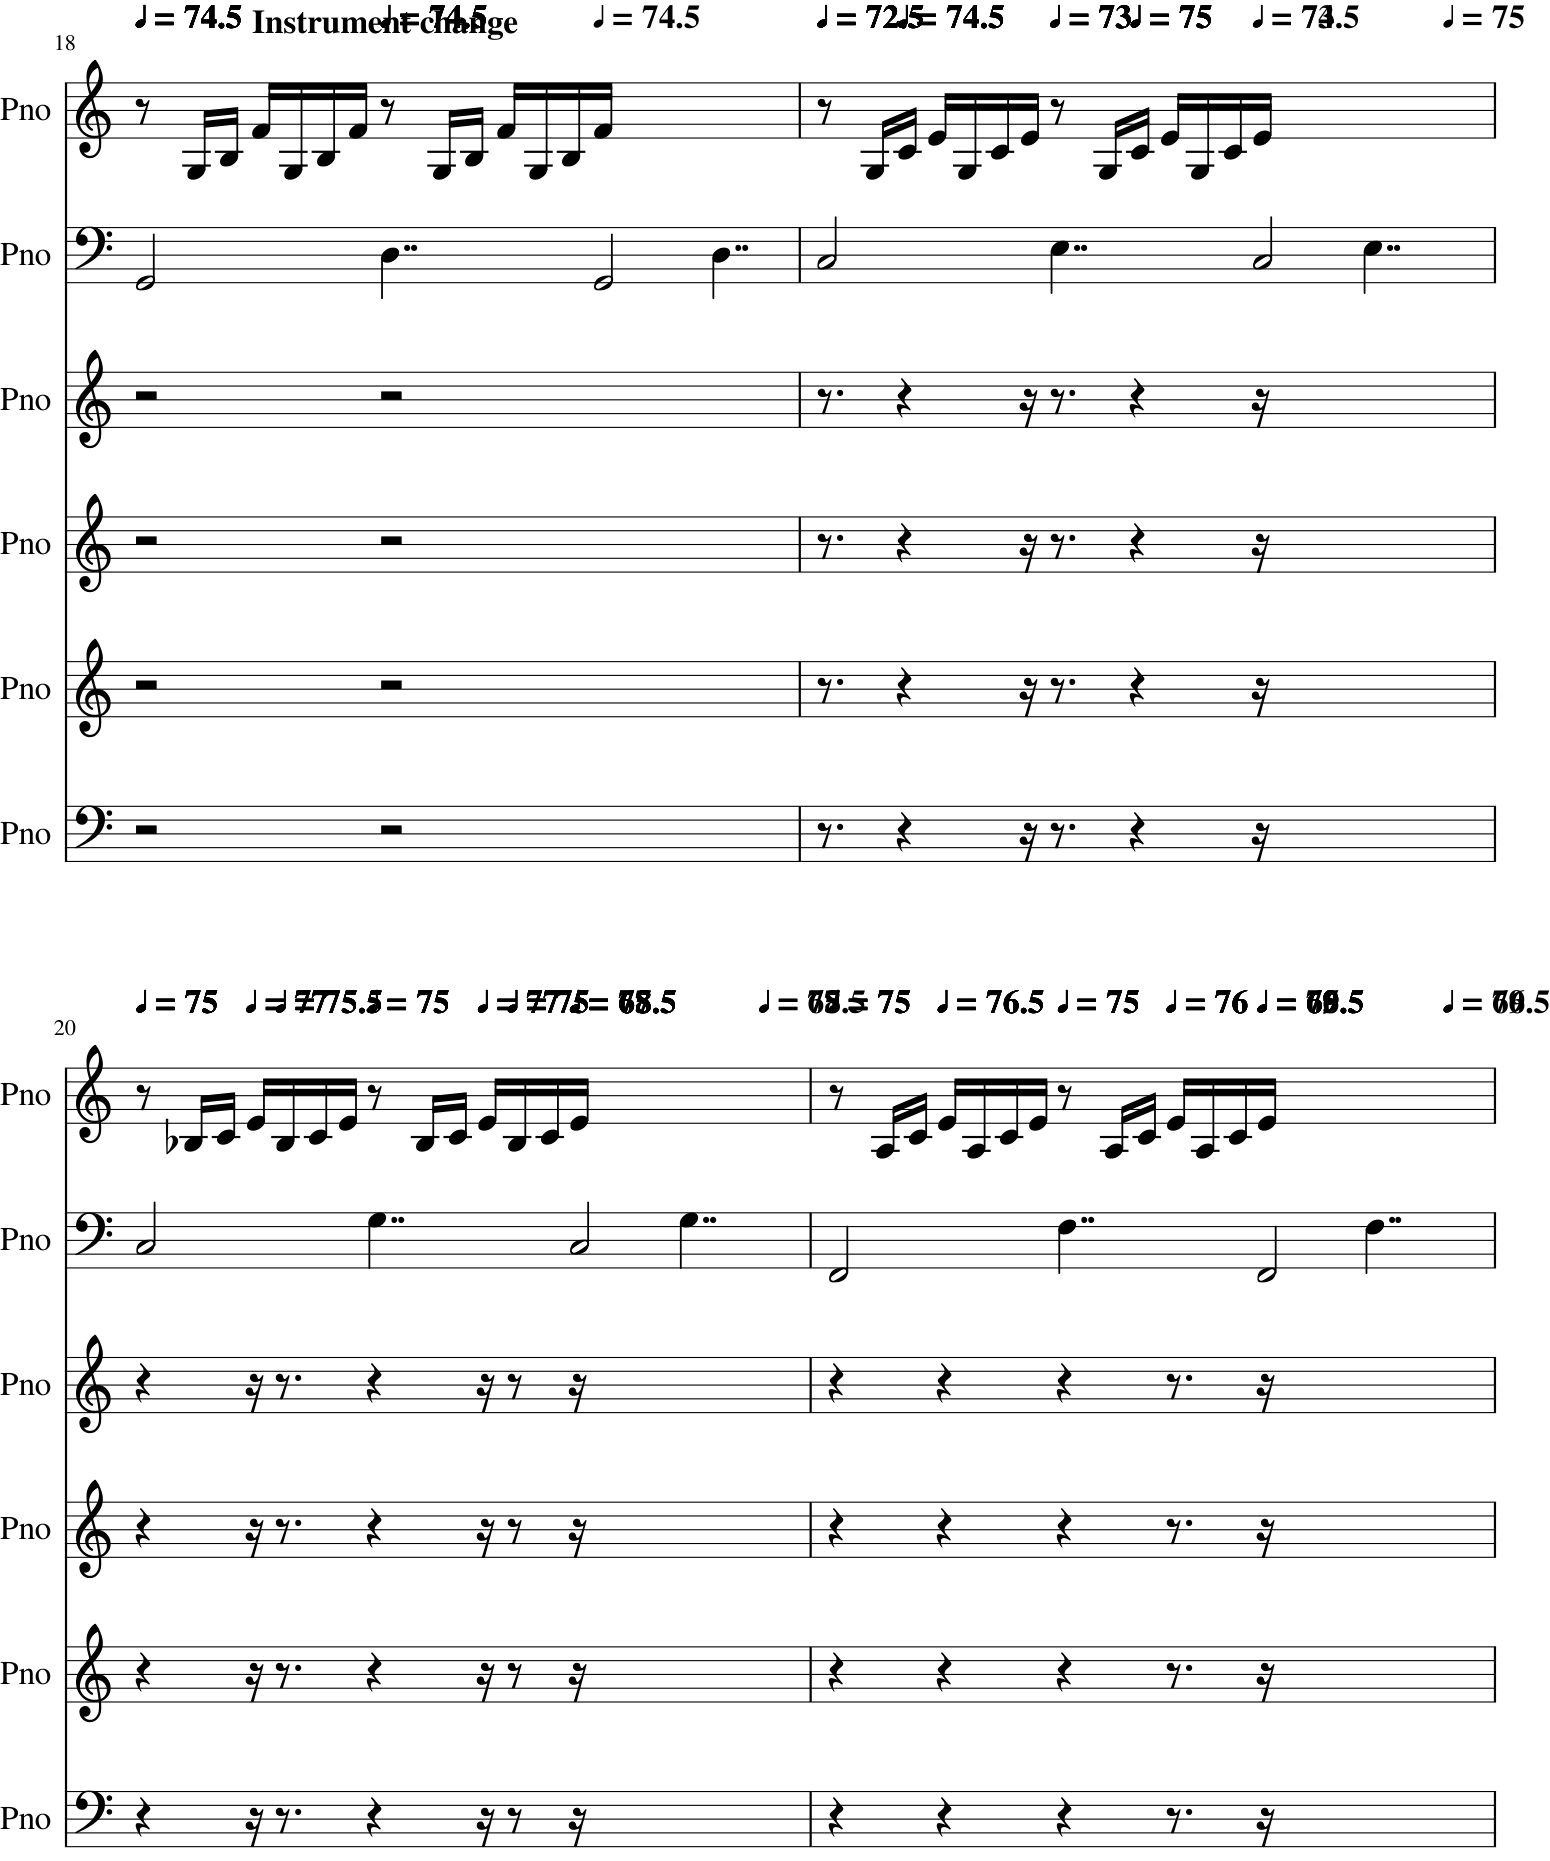

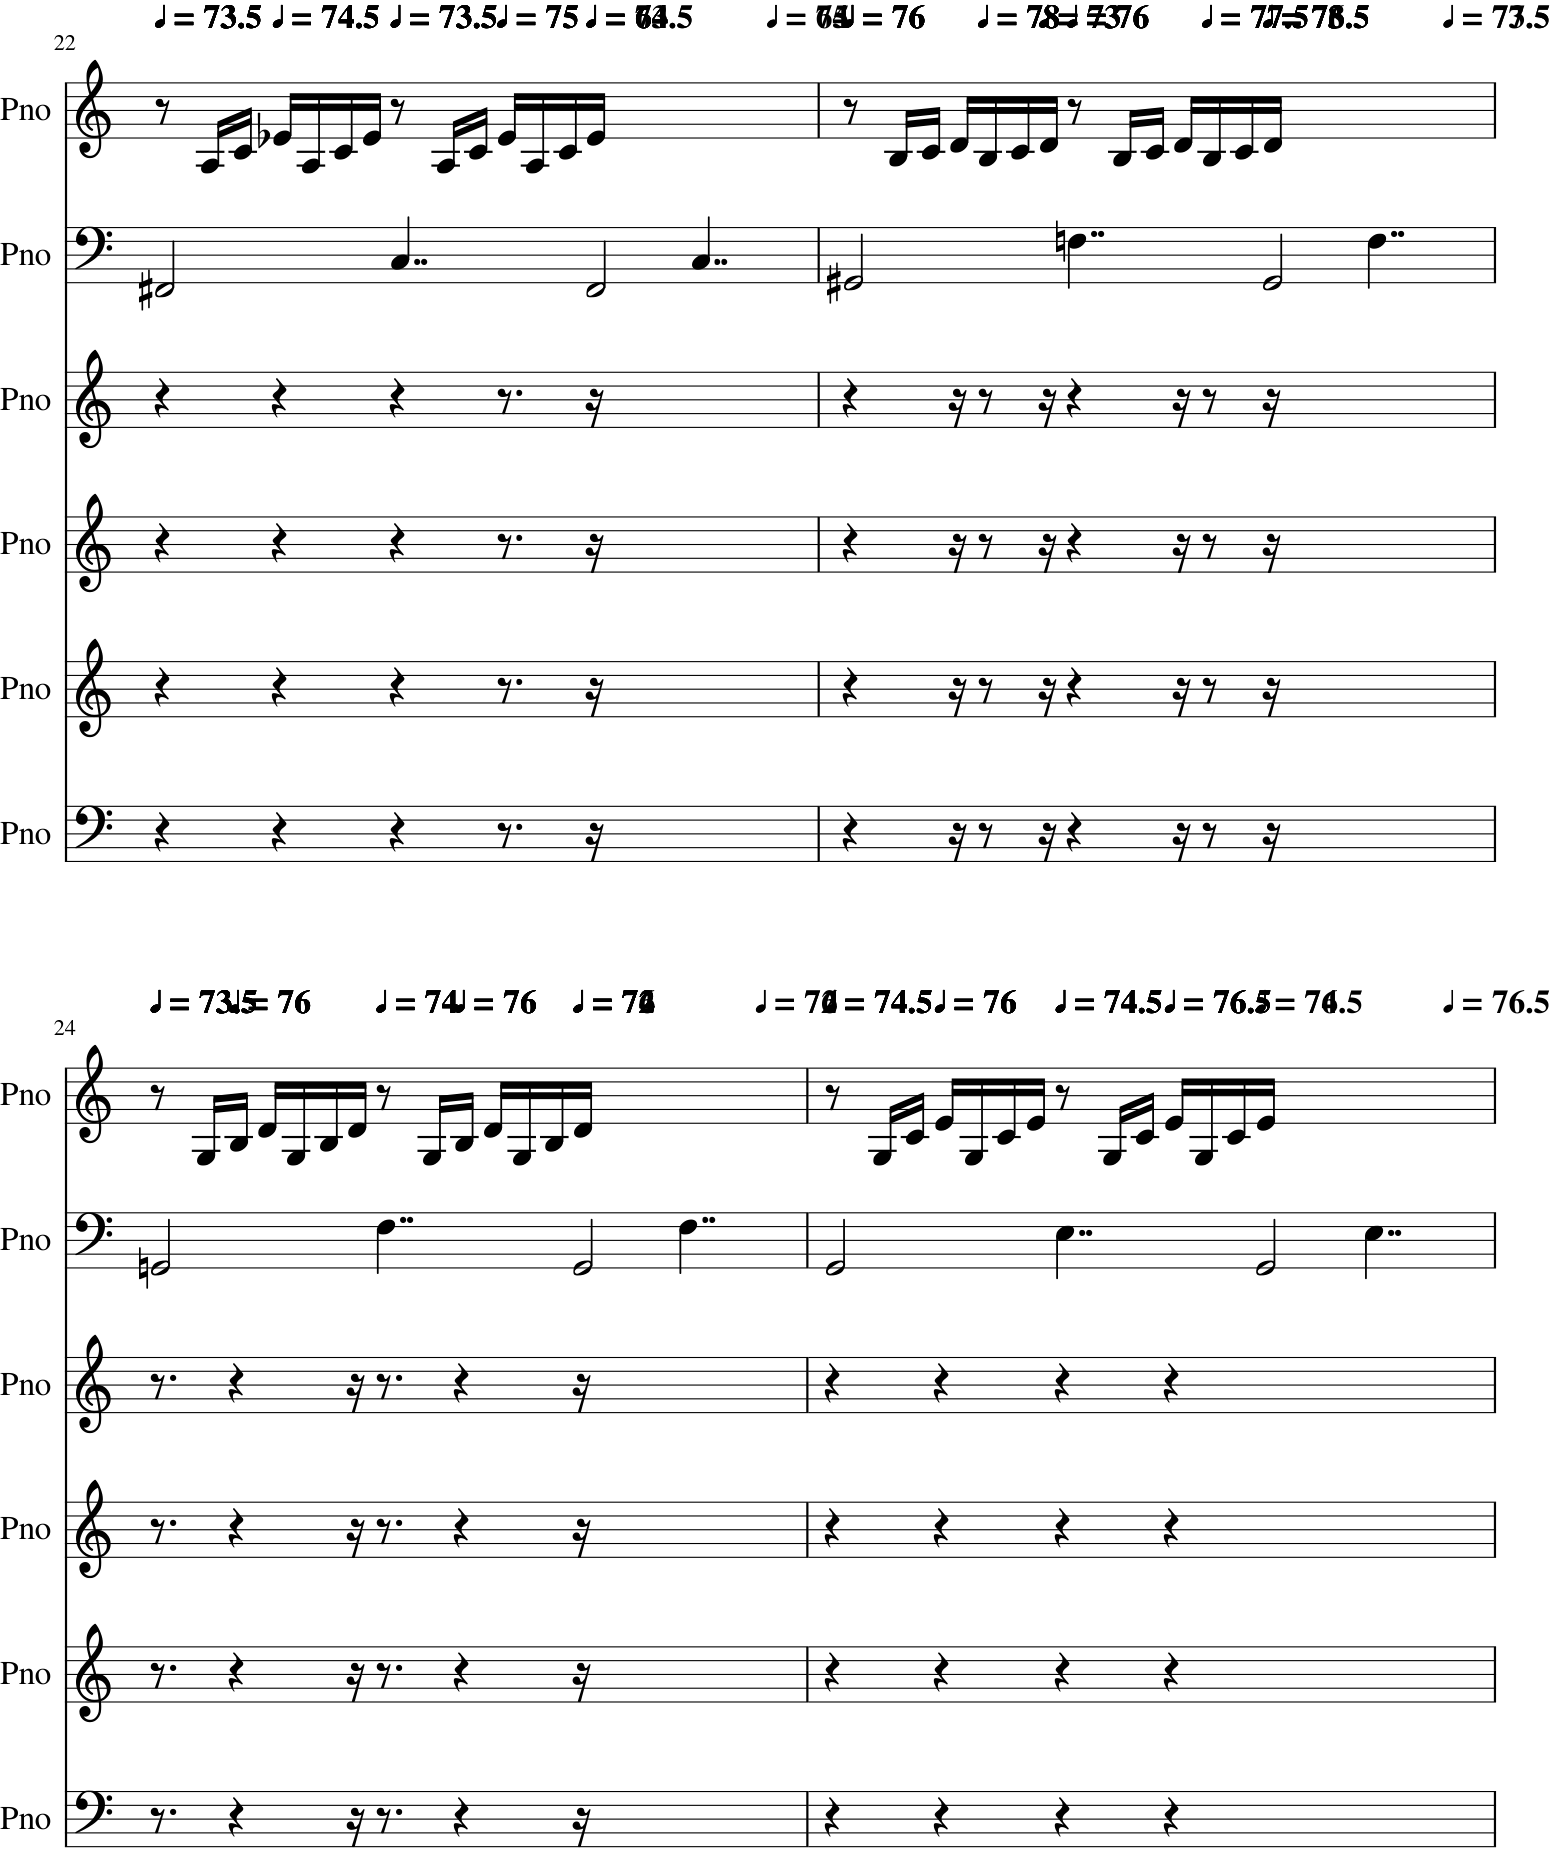

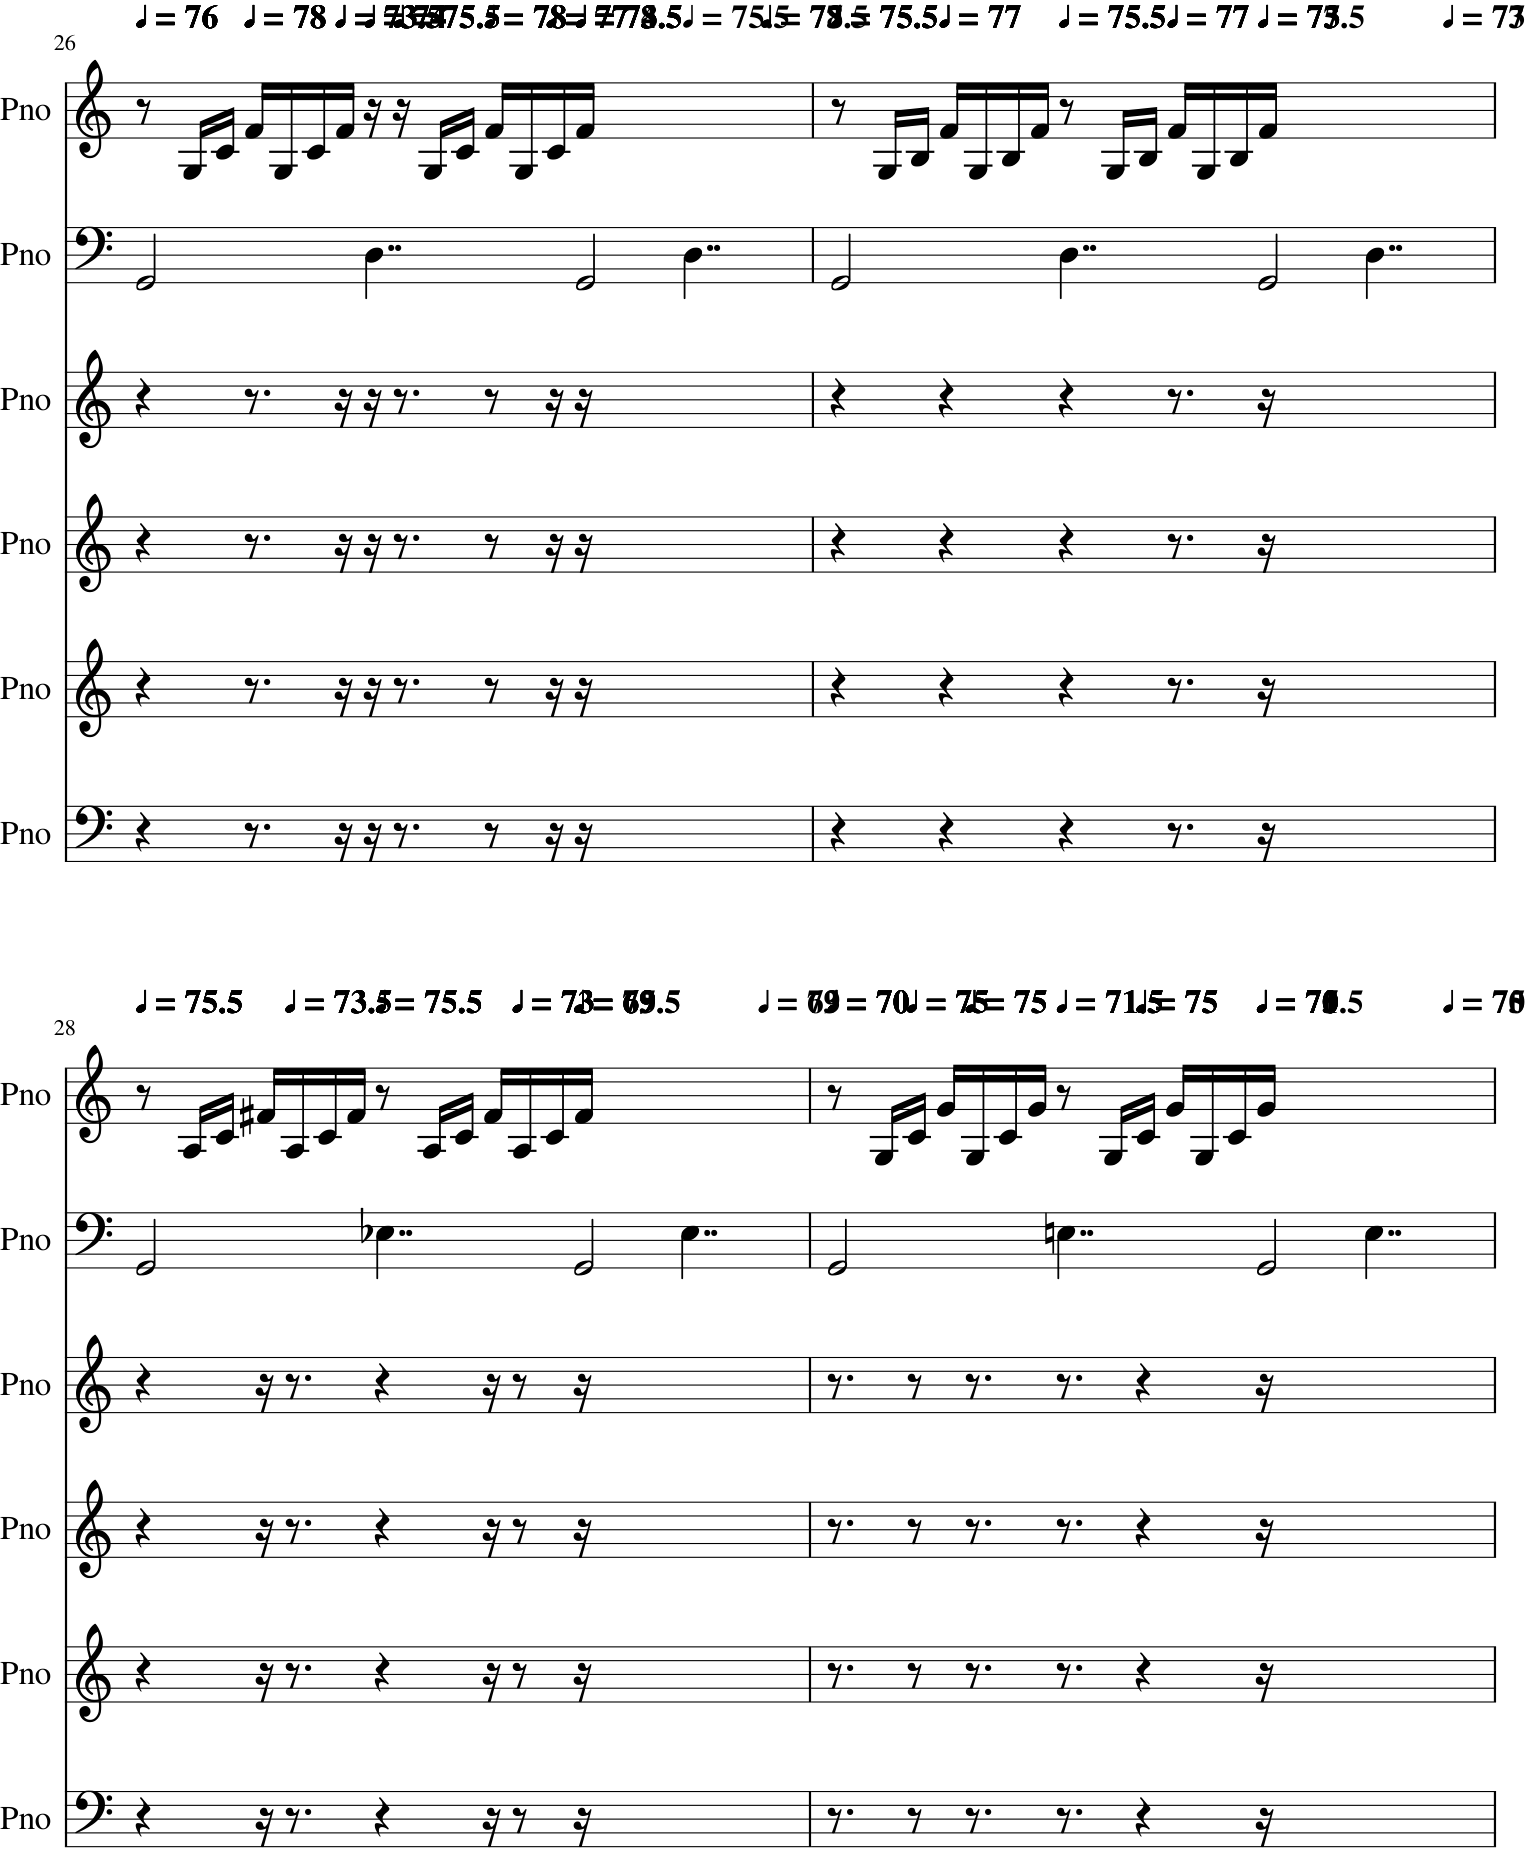

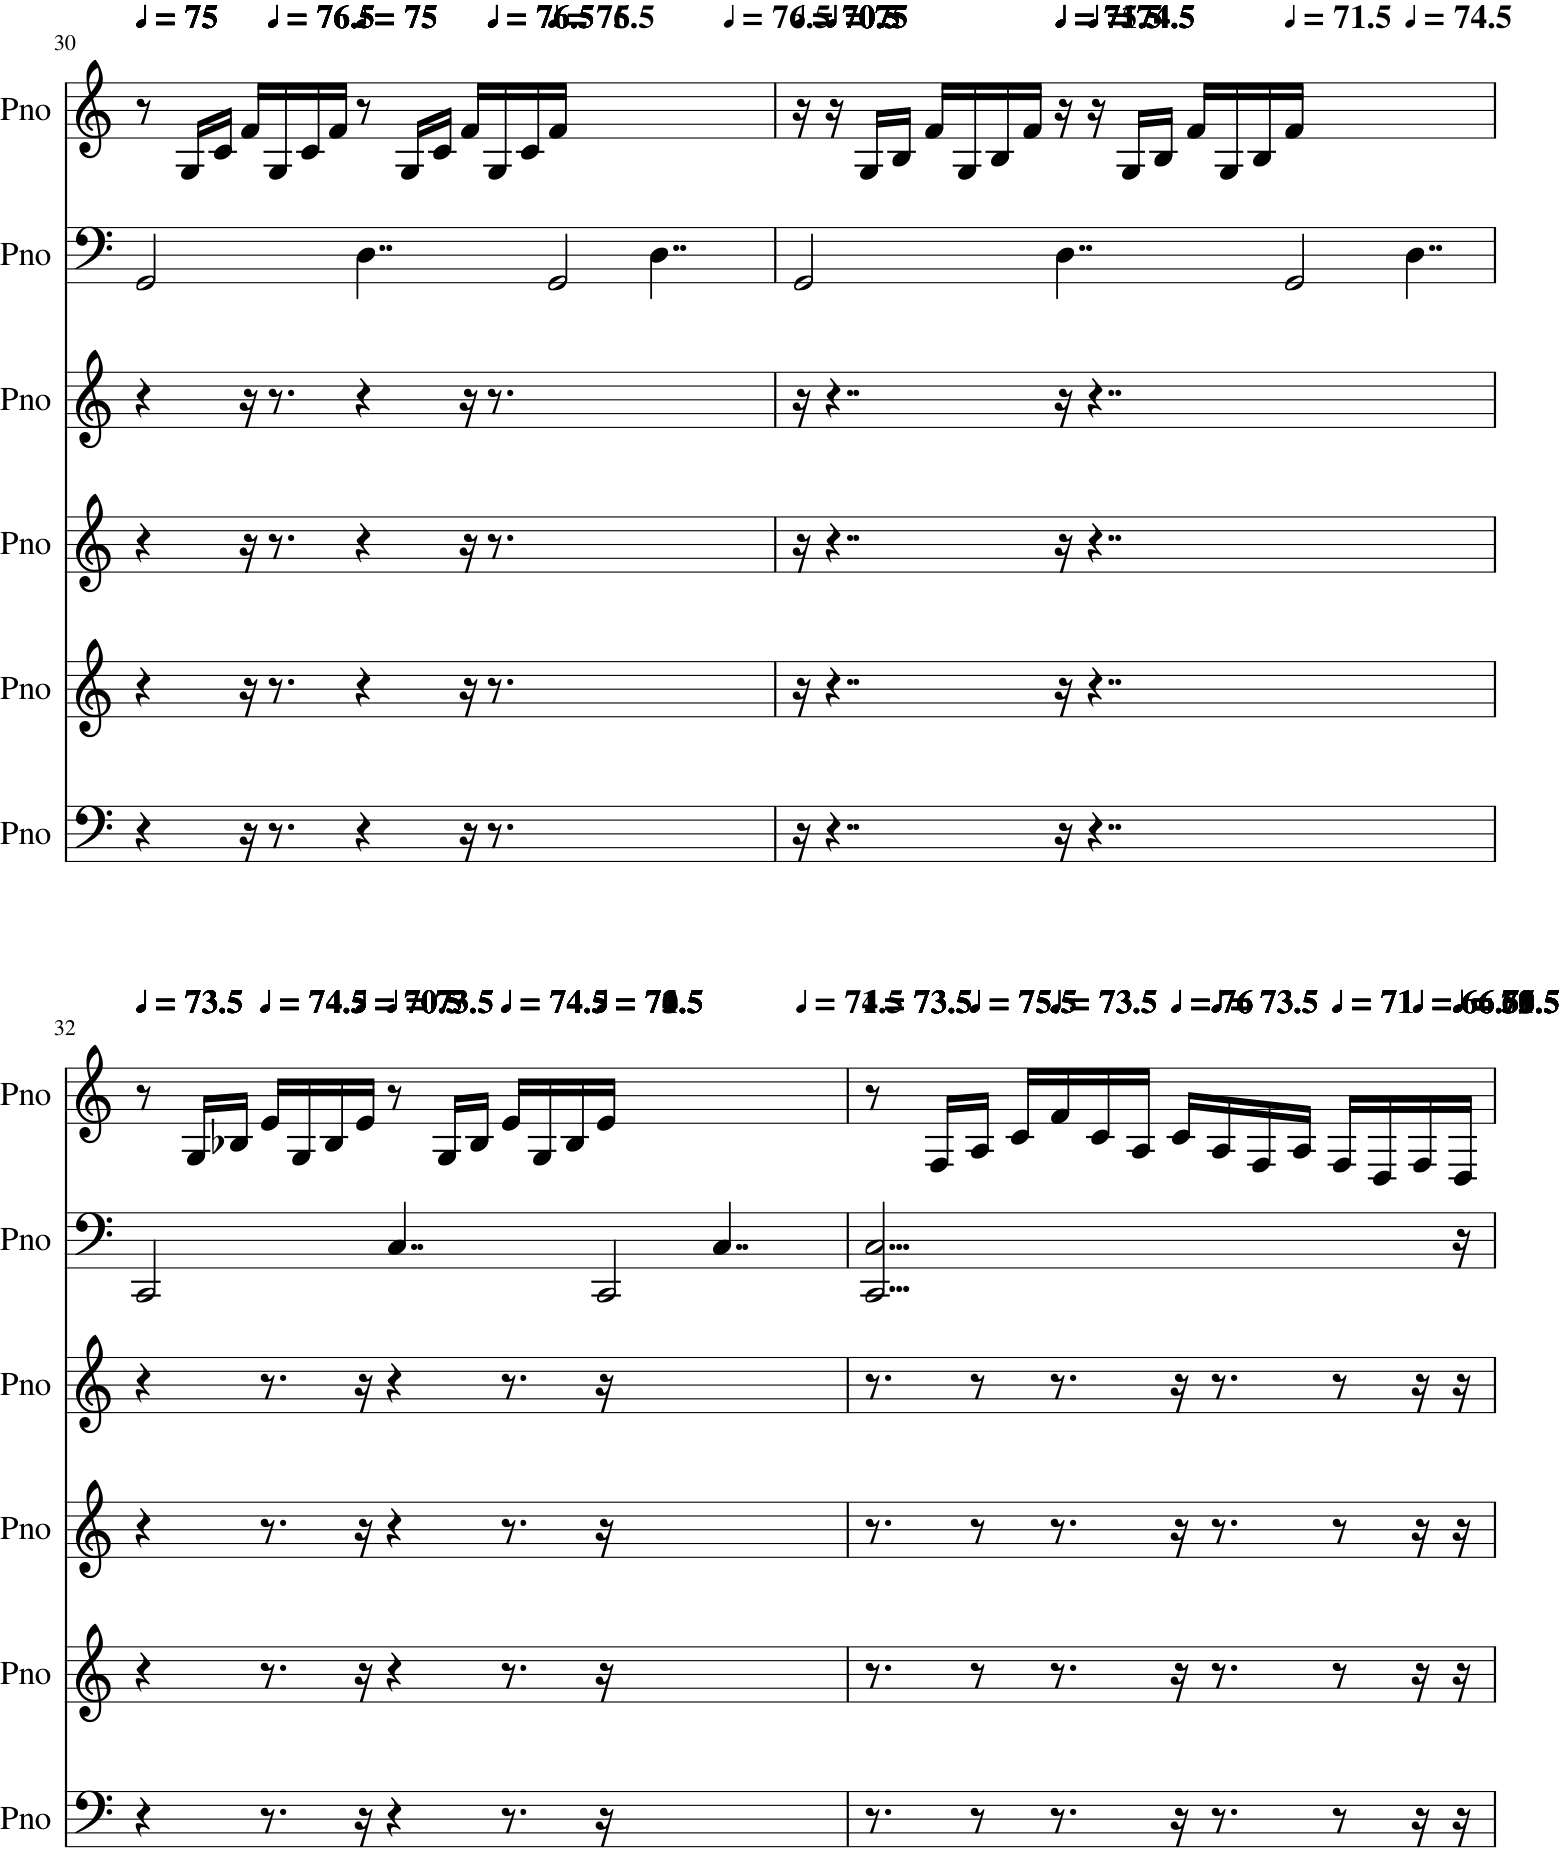

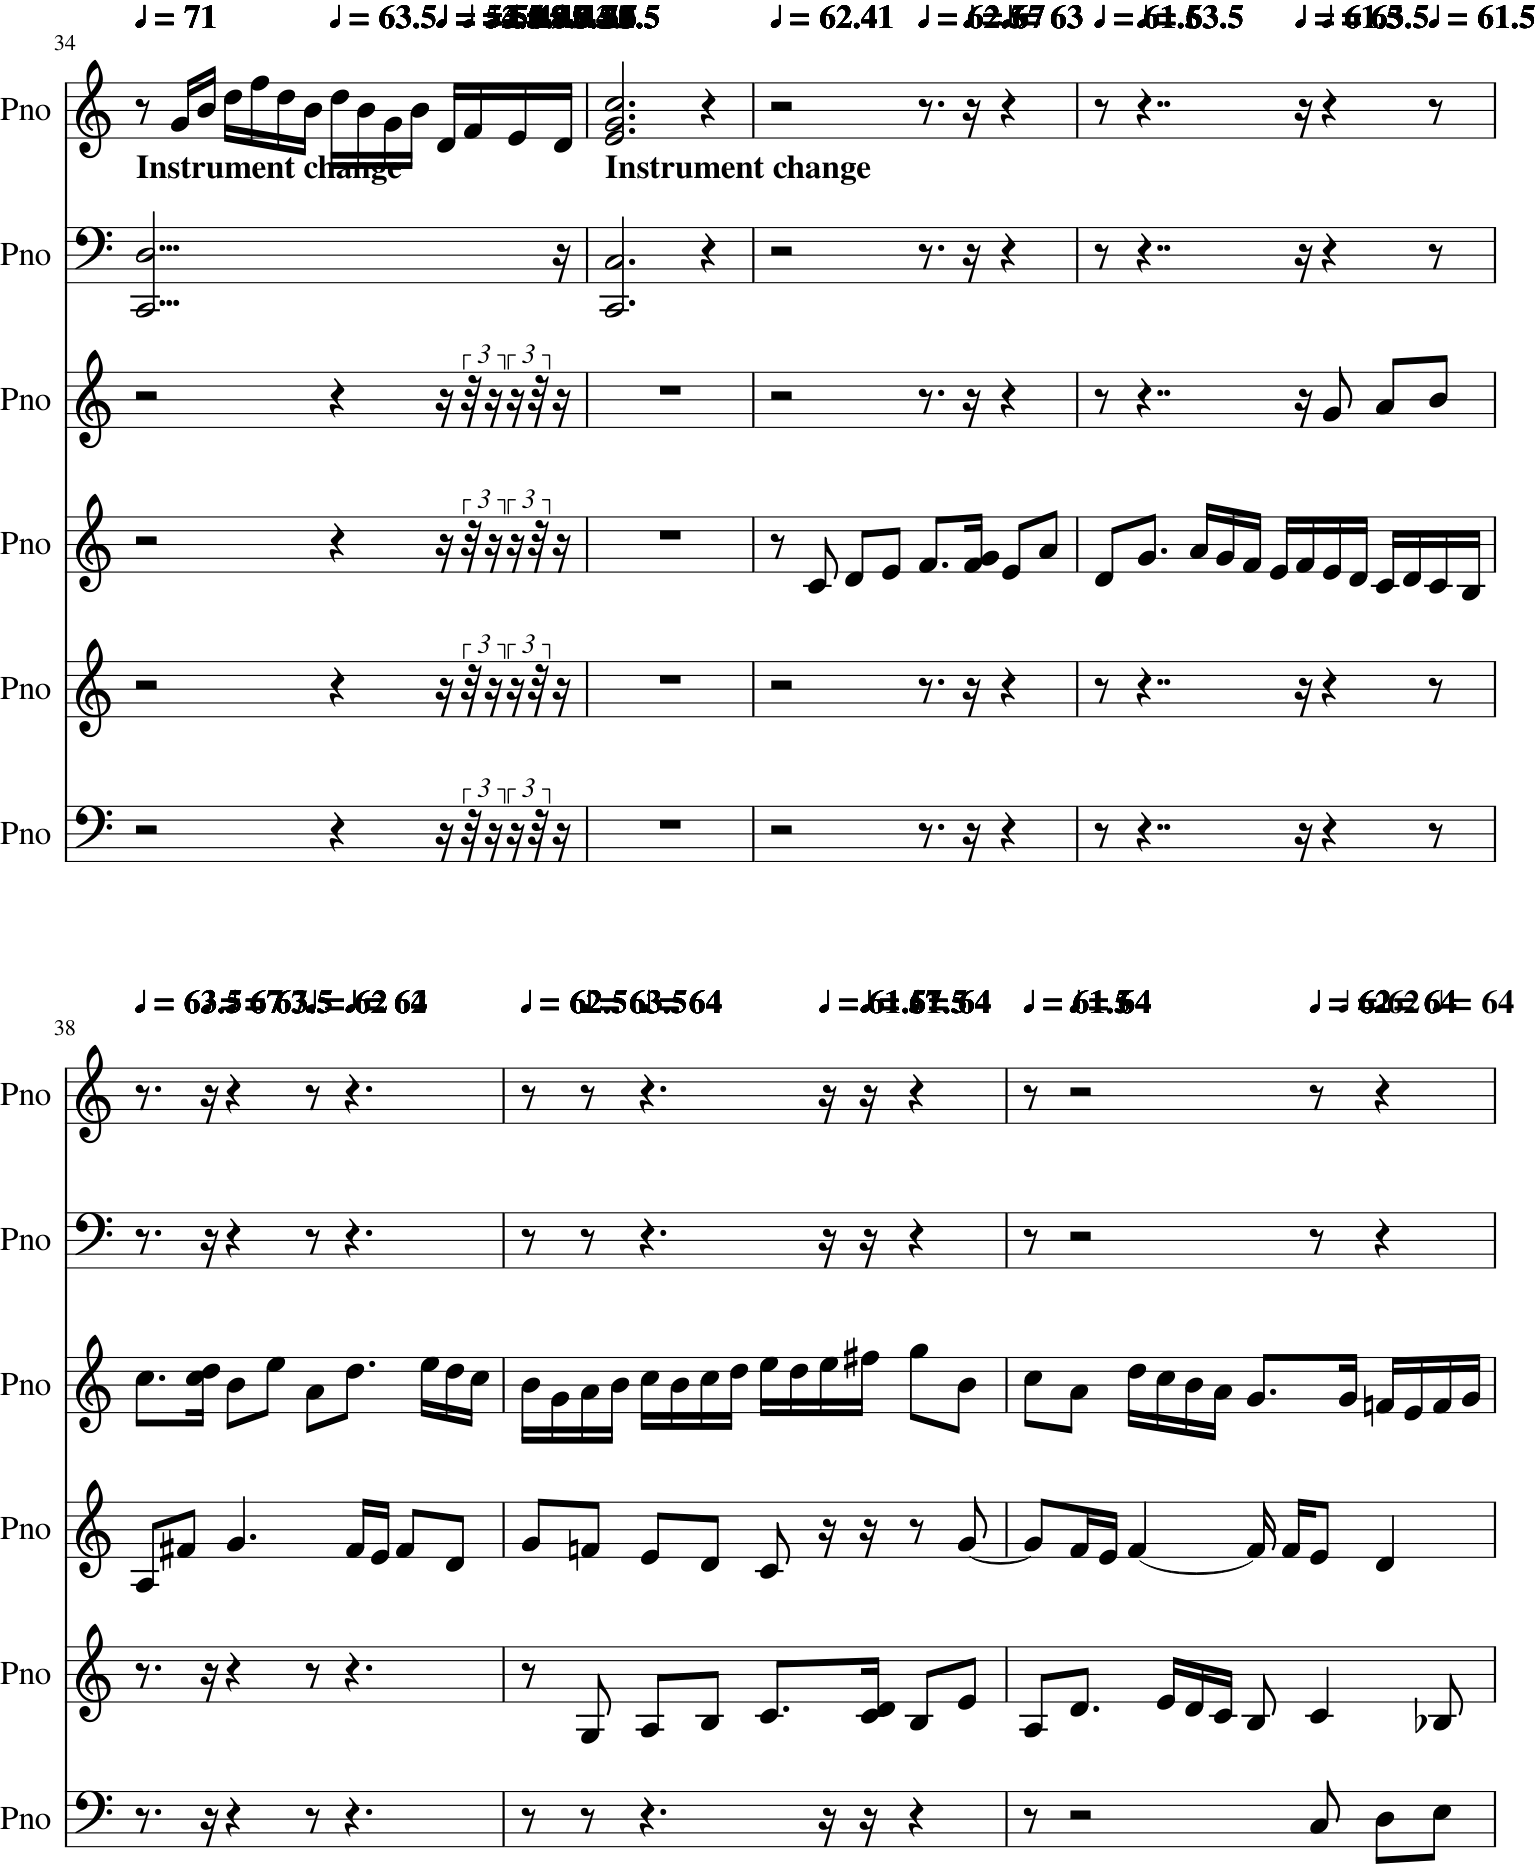

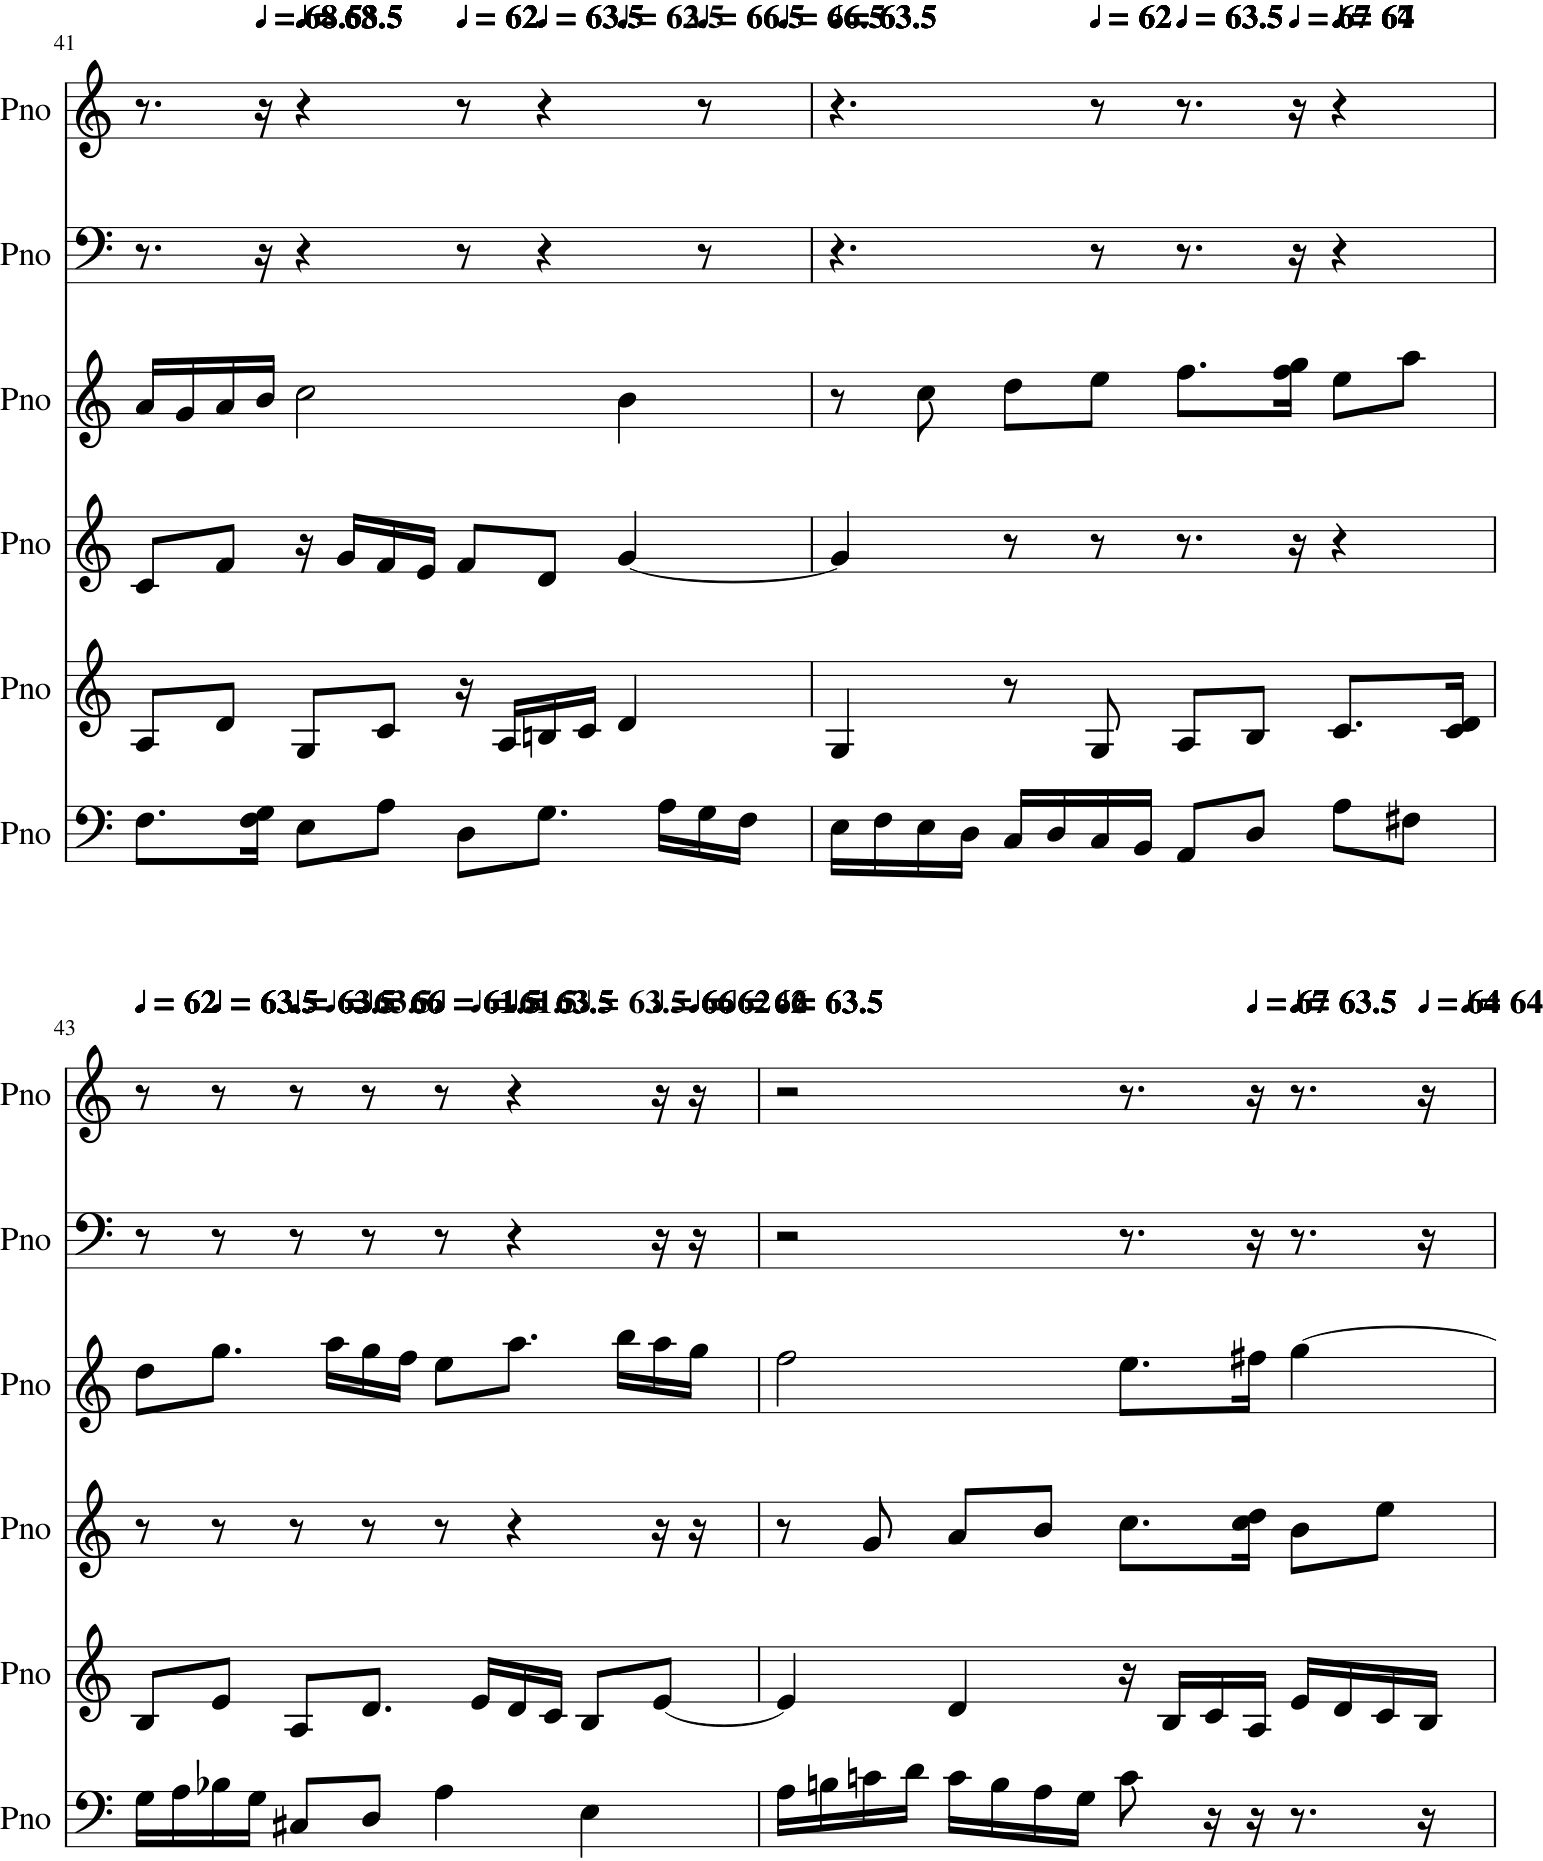

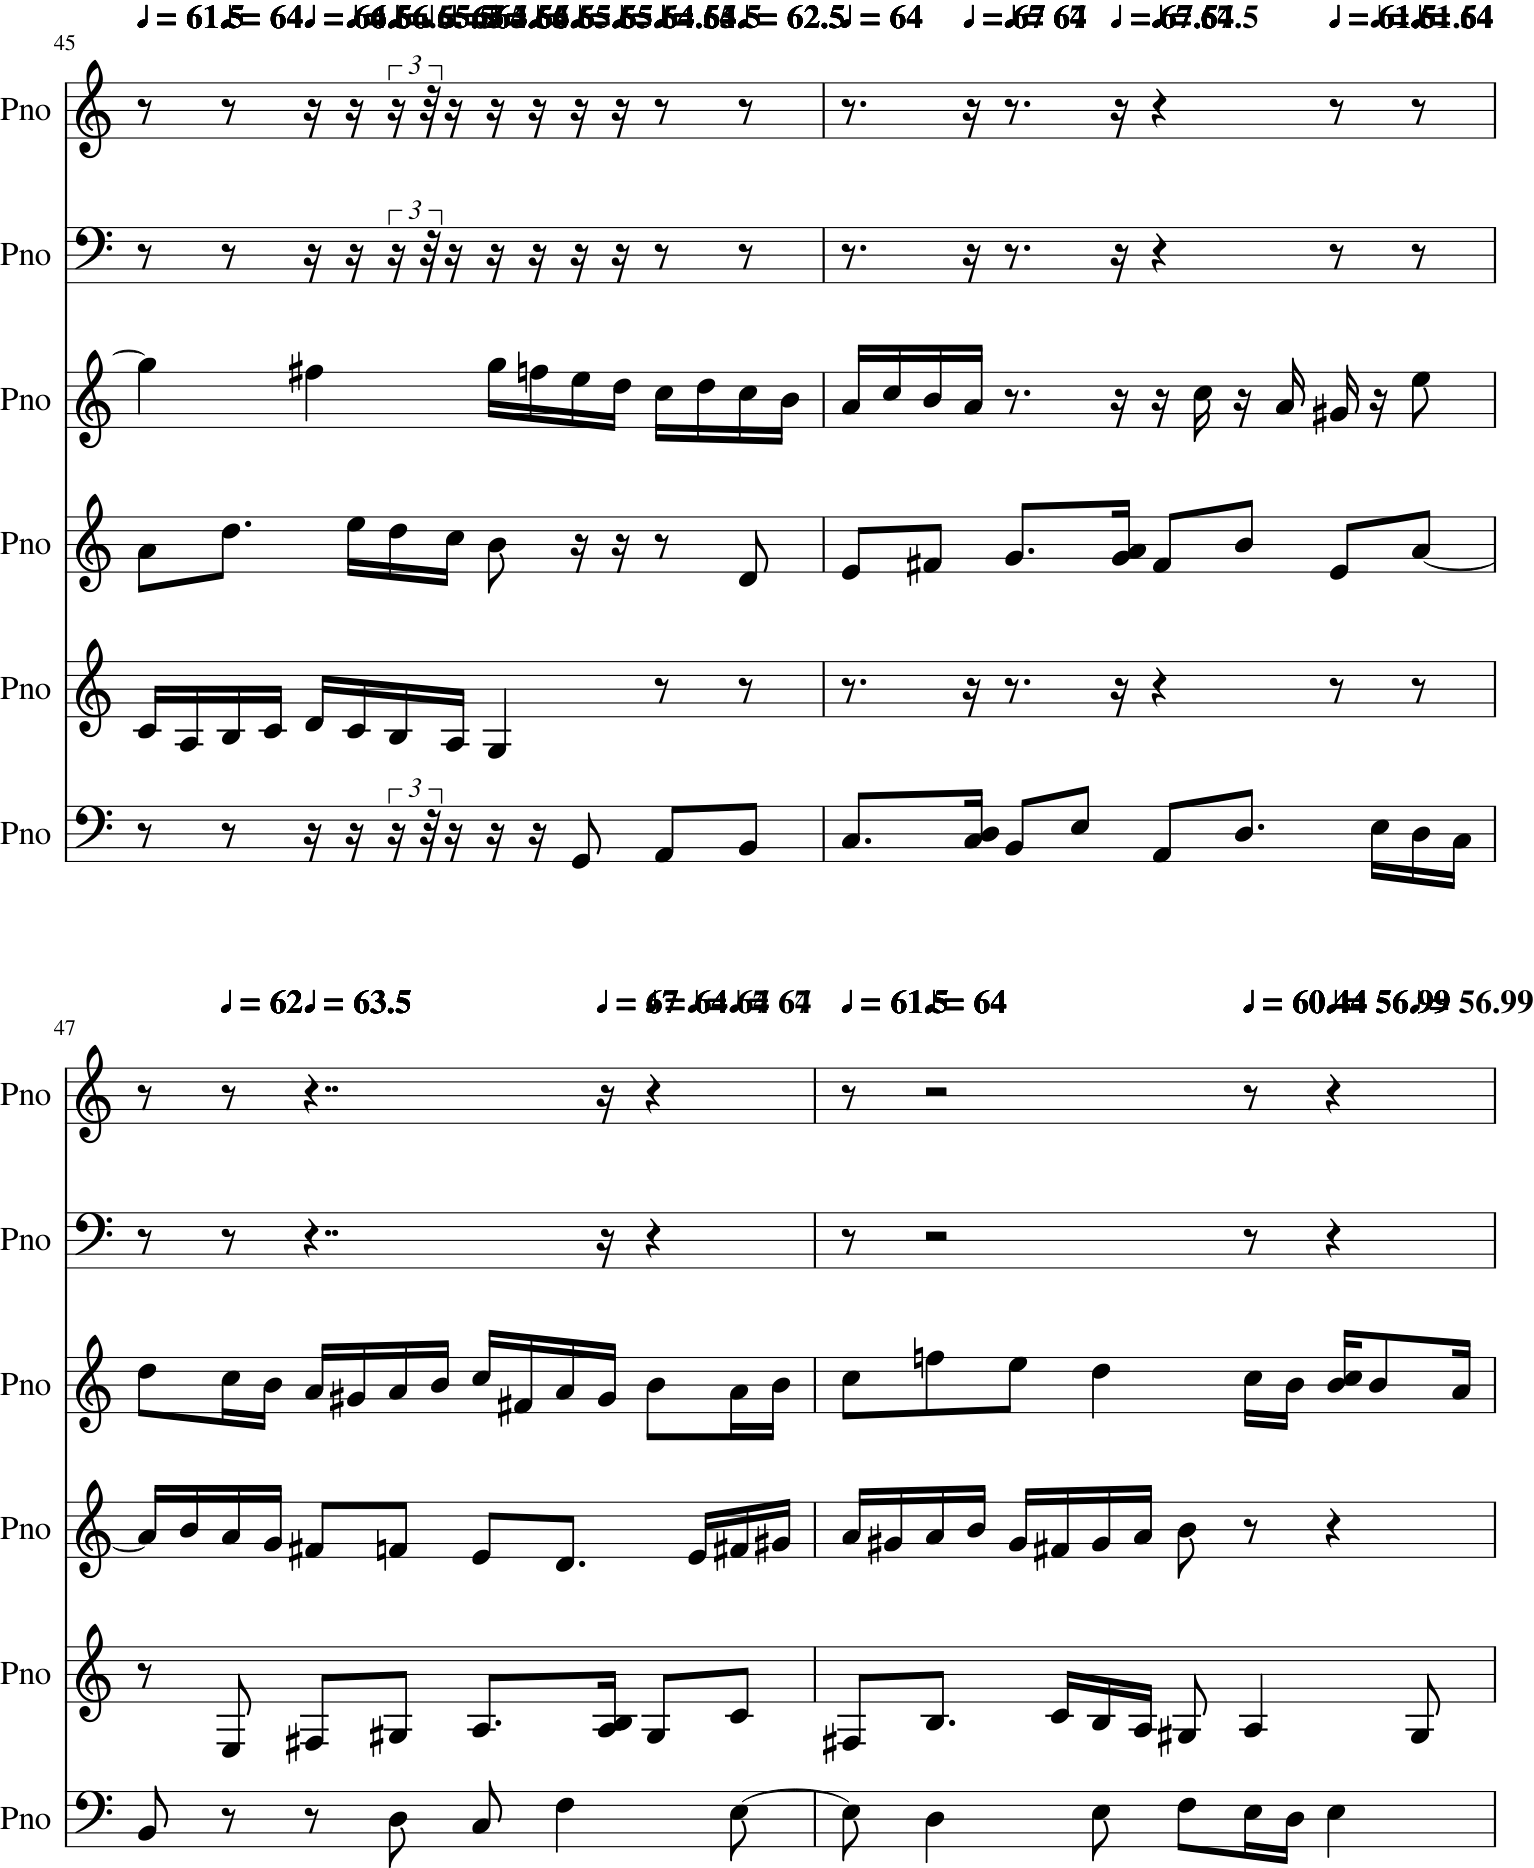

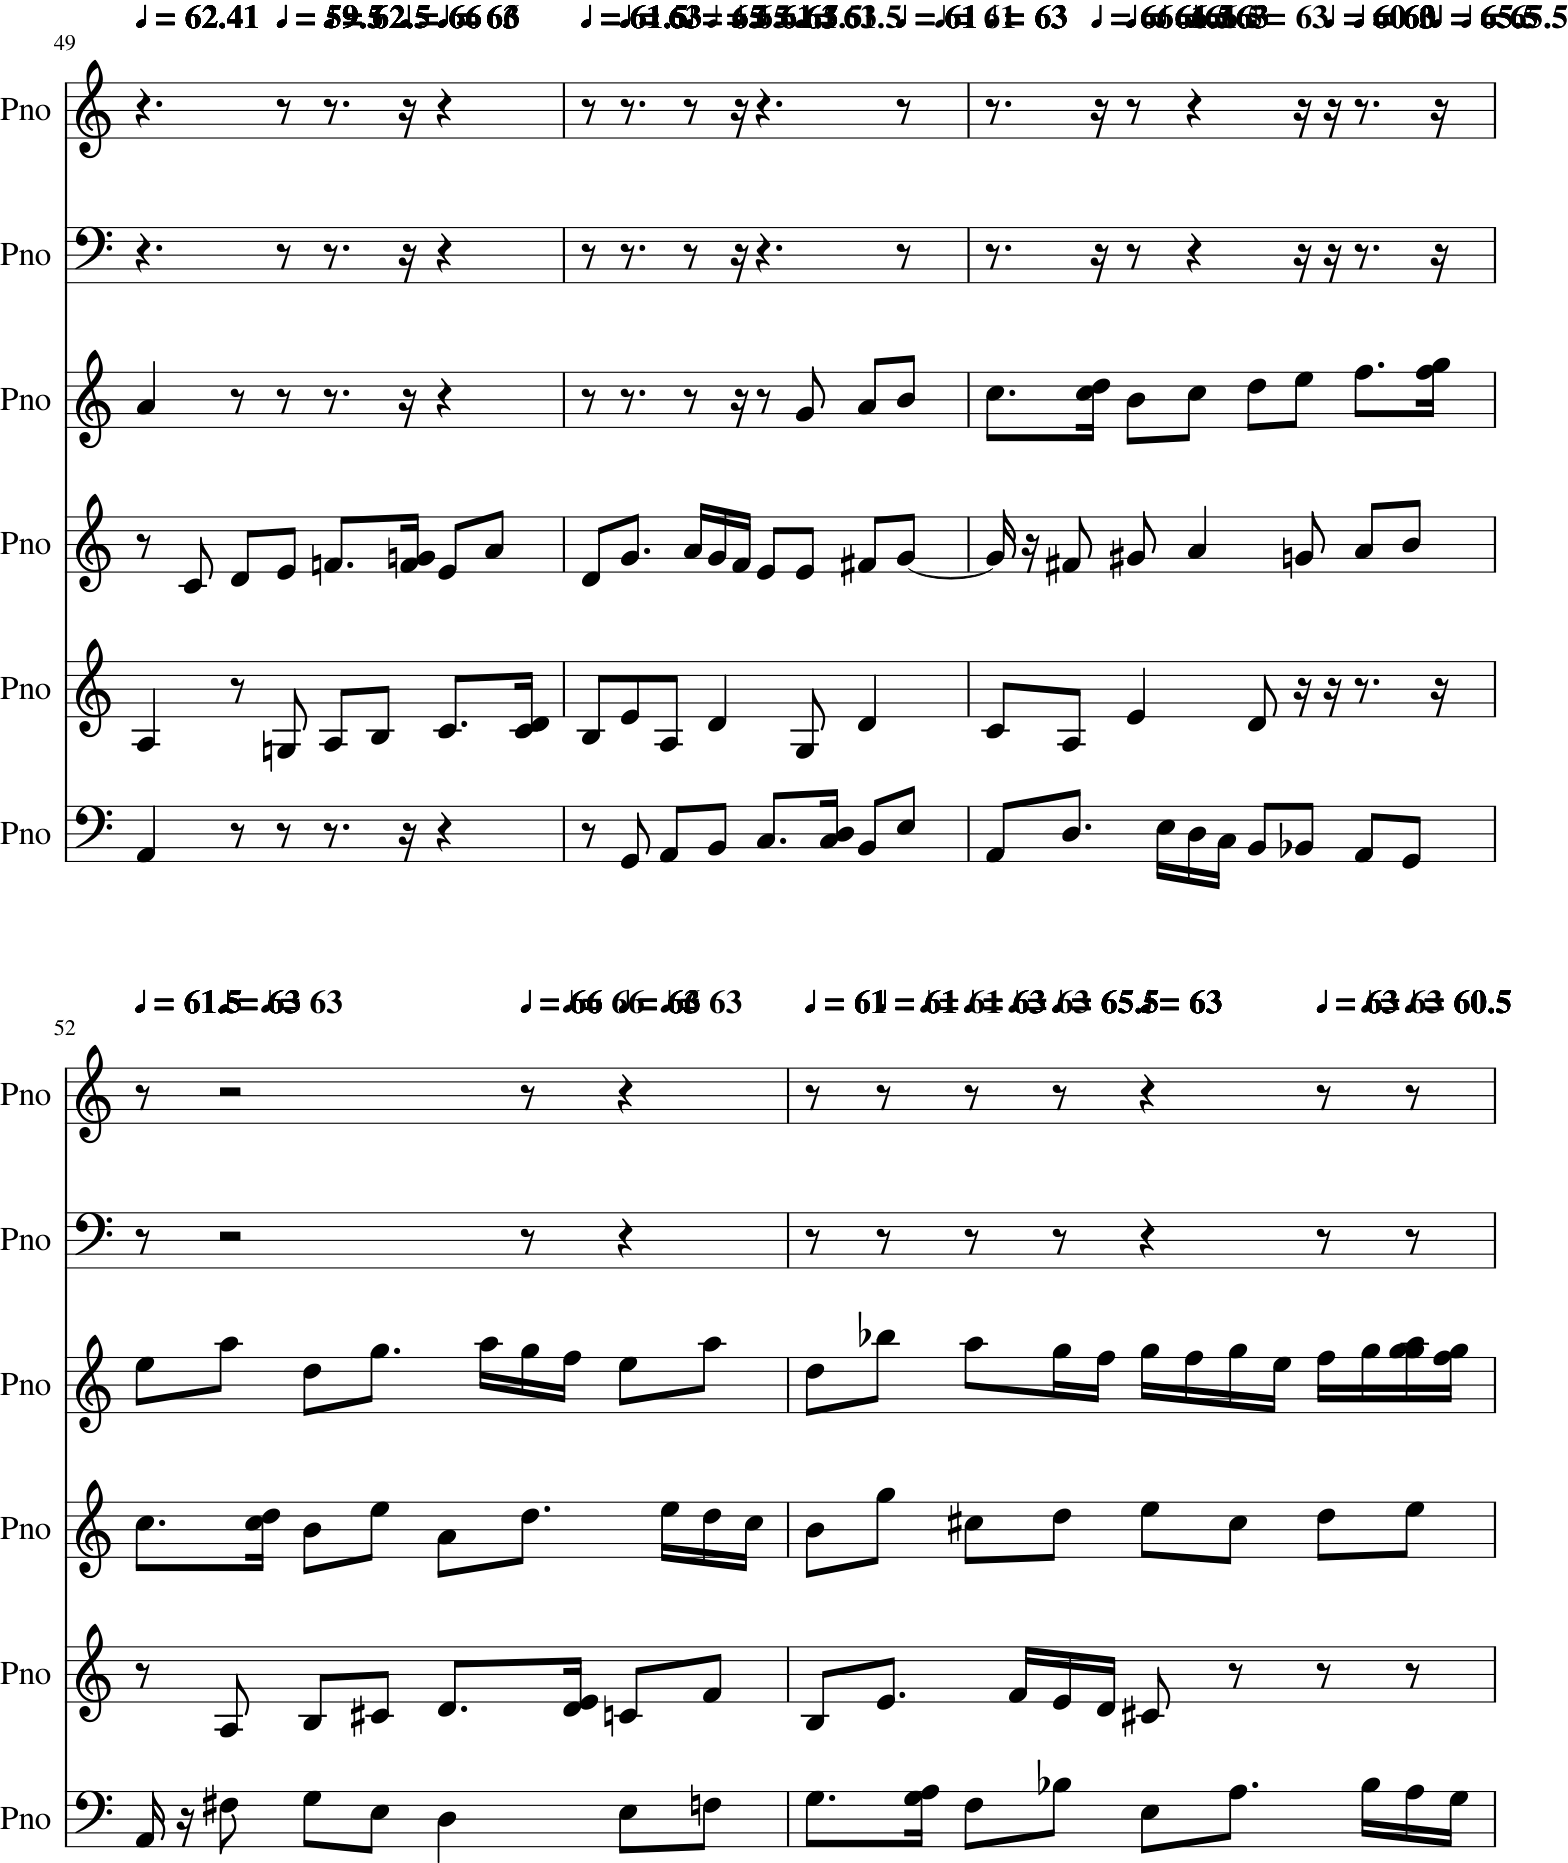

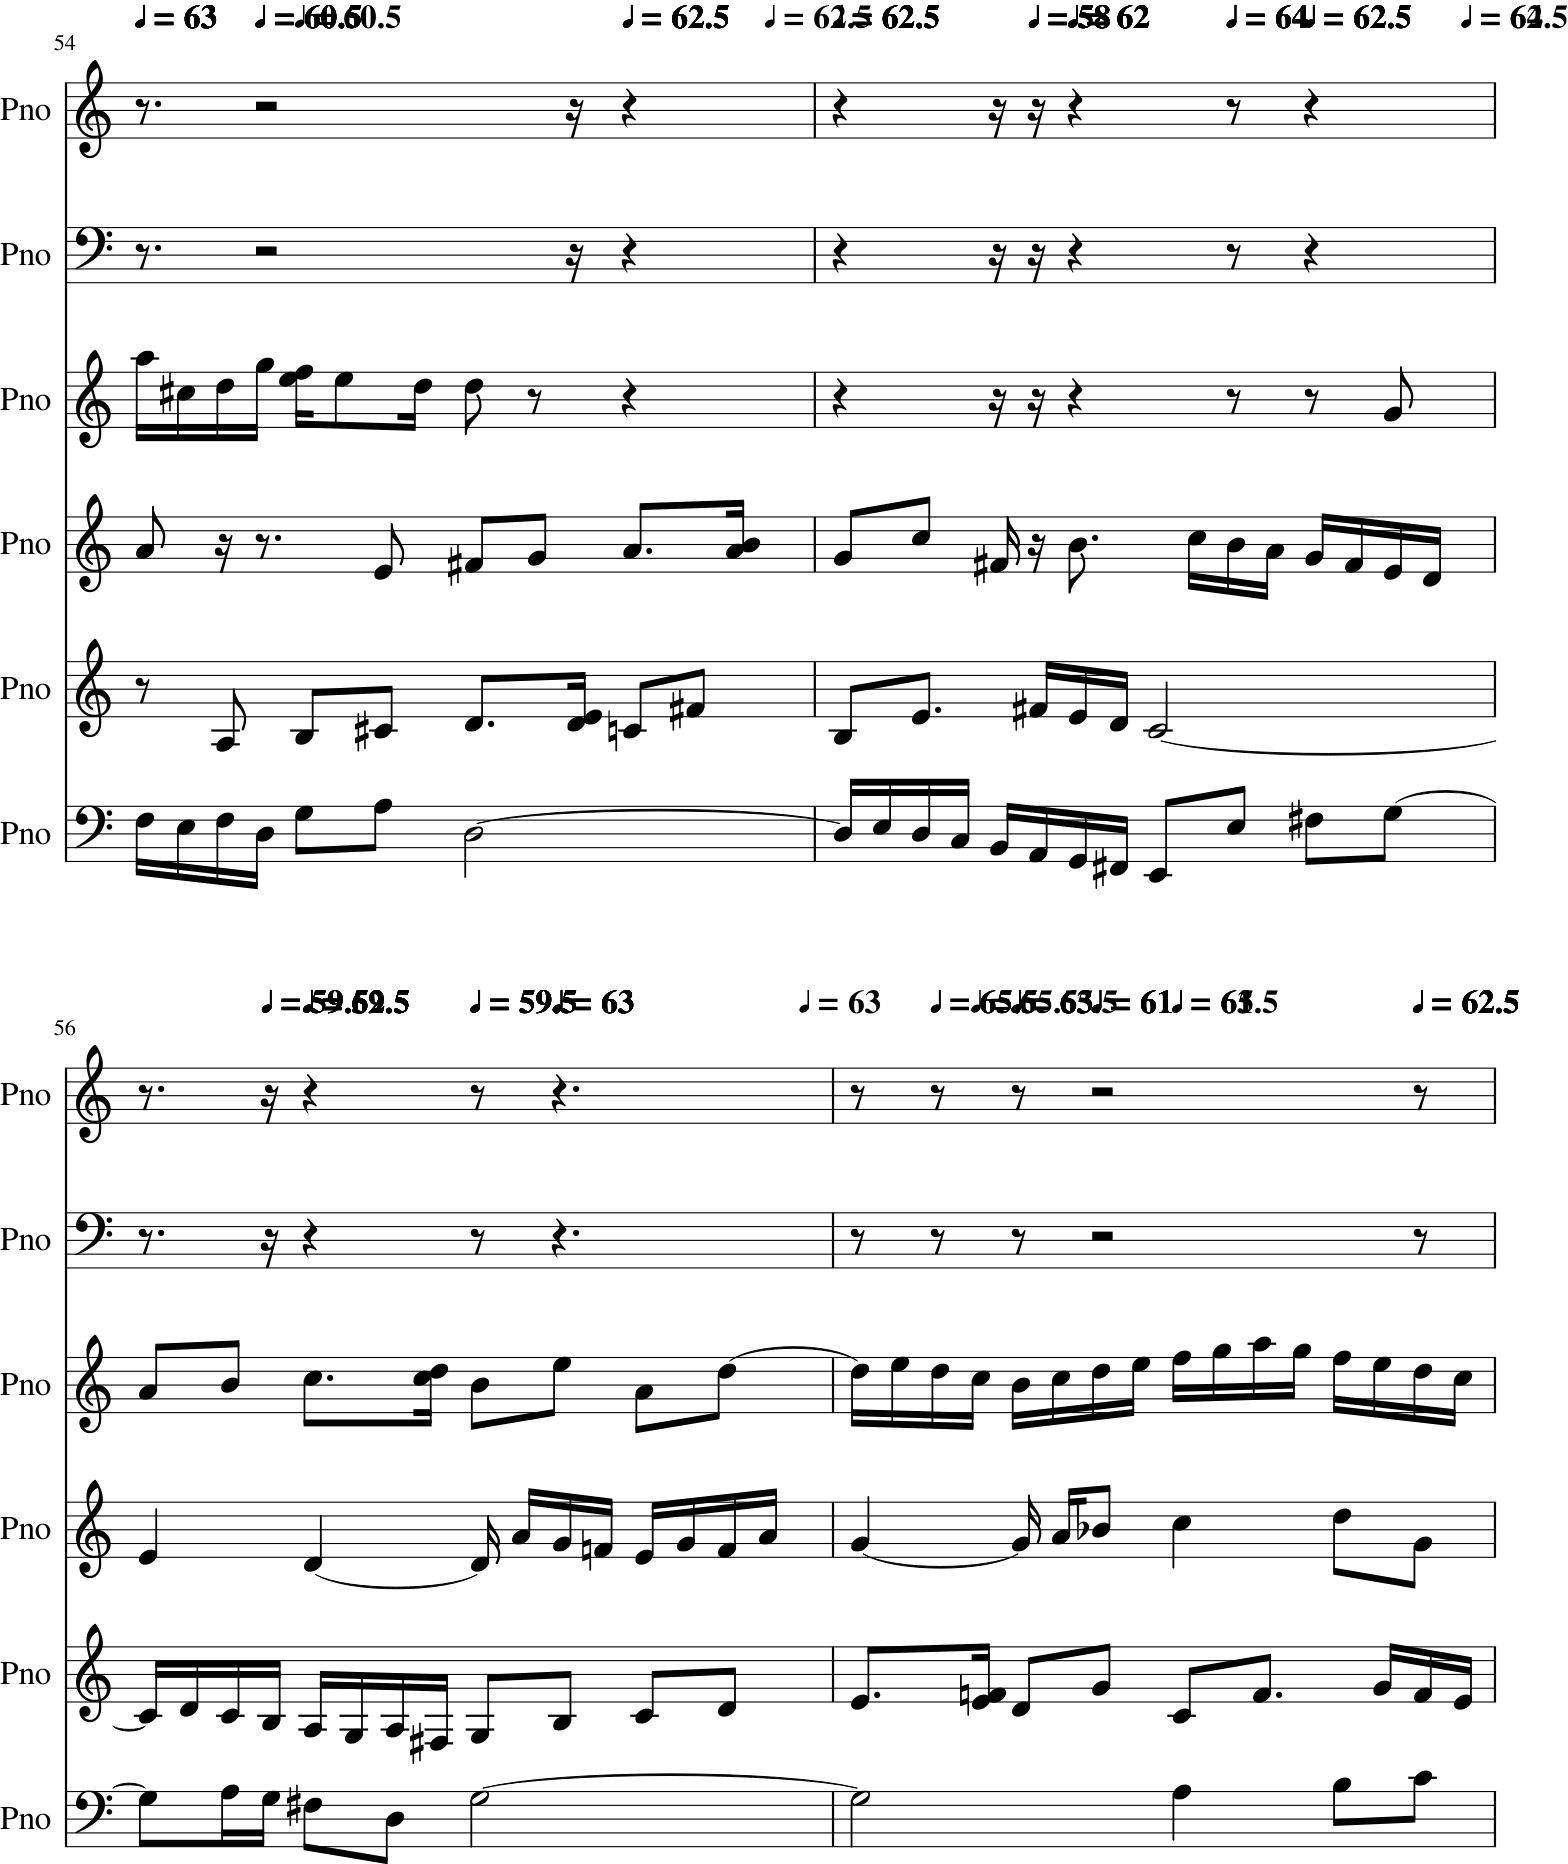

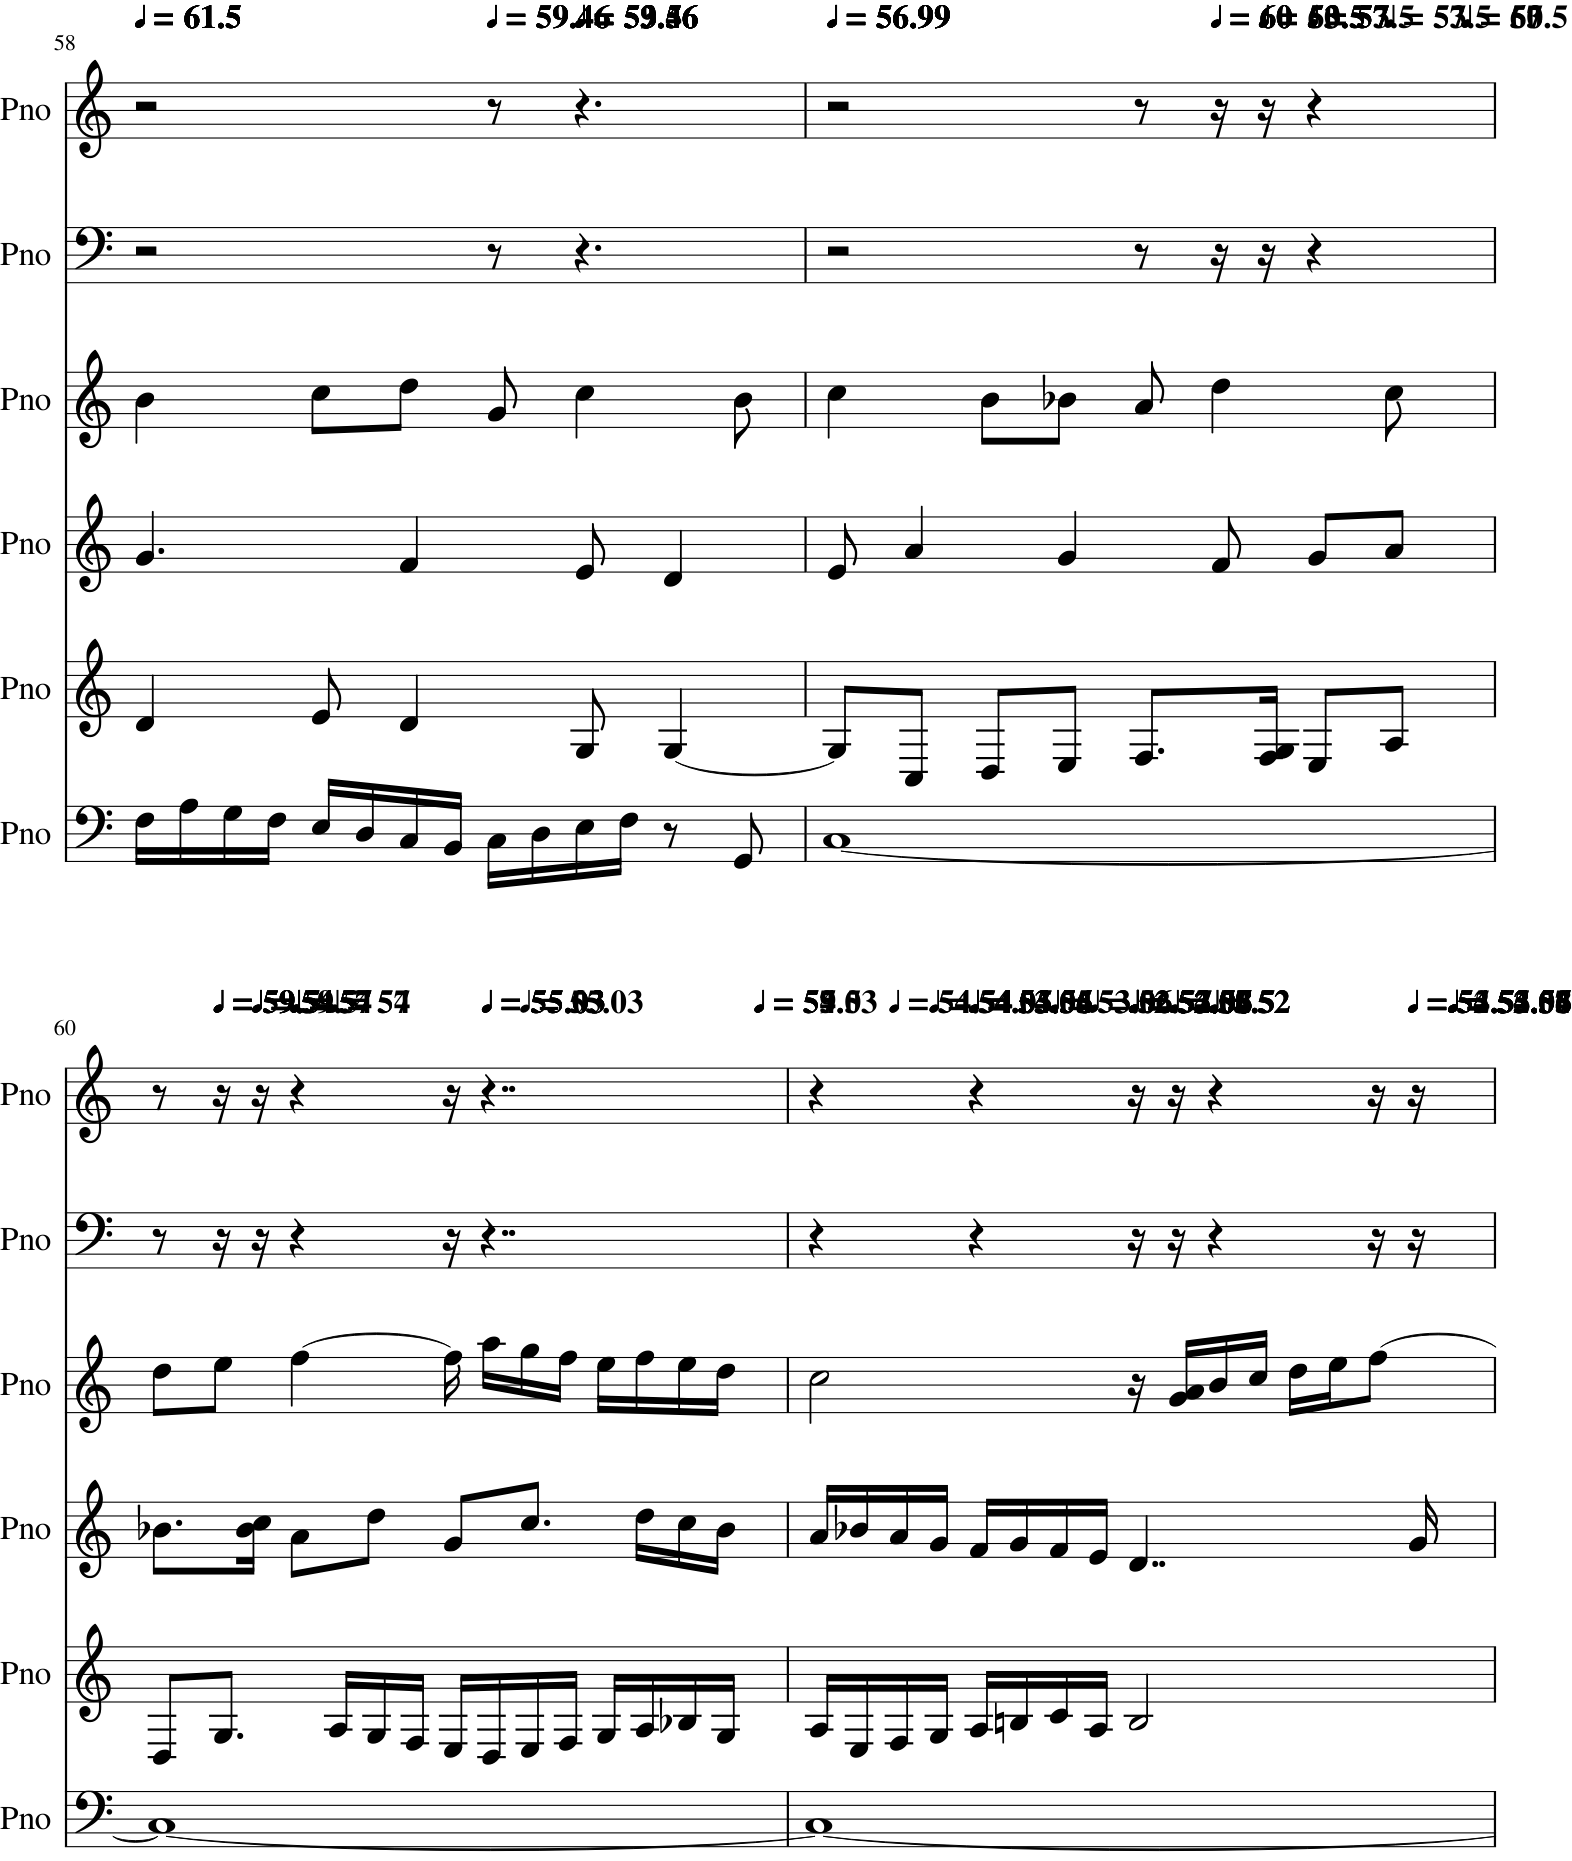

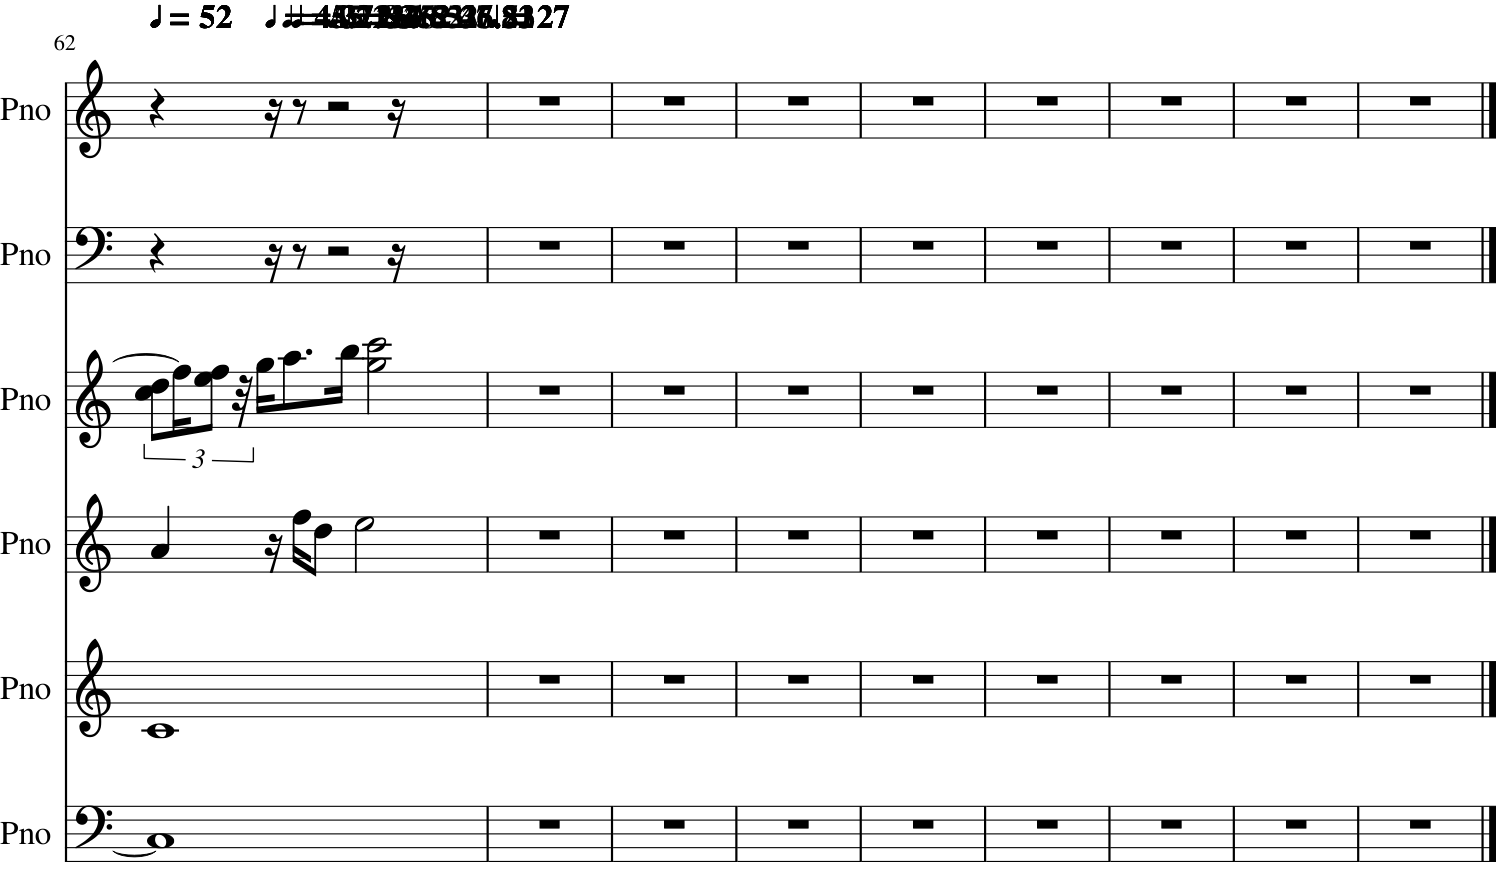

In [17]:
  from music21 import midi, stream, metadata

  # Load the MIDI file
  original_midi = midi.MidiFile()
  original_midi.open('/content/drive/MyDrive/bach_midi/bach_846.mid')  # replace with your file path
  original_midi.read()
  original_midi.close()

  # Convert MIDI file to stream for visualization
  original_stream = midi.translate.midiFileToStream(original_midi)
  original_stream.metadata = metadata.Metadata()
  original_stream.metadata.title = 'Original'

  # Show the original music sheet
  original_stream.show()


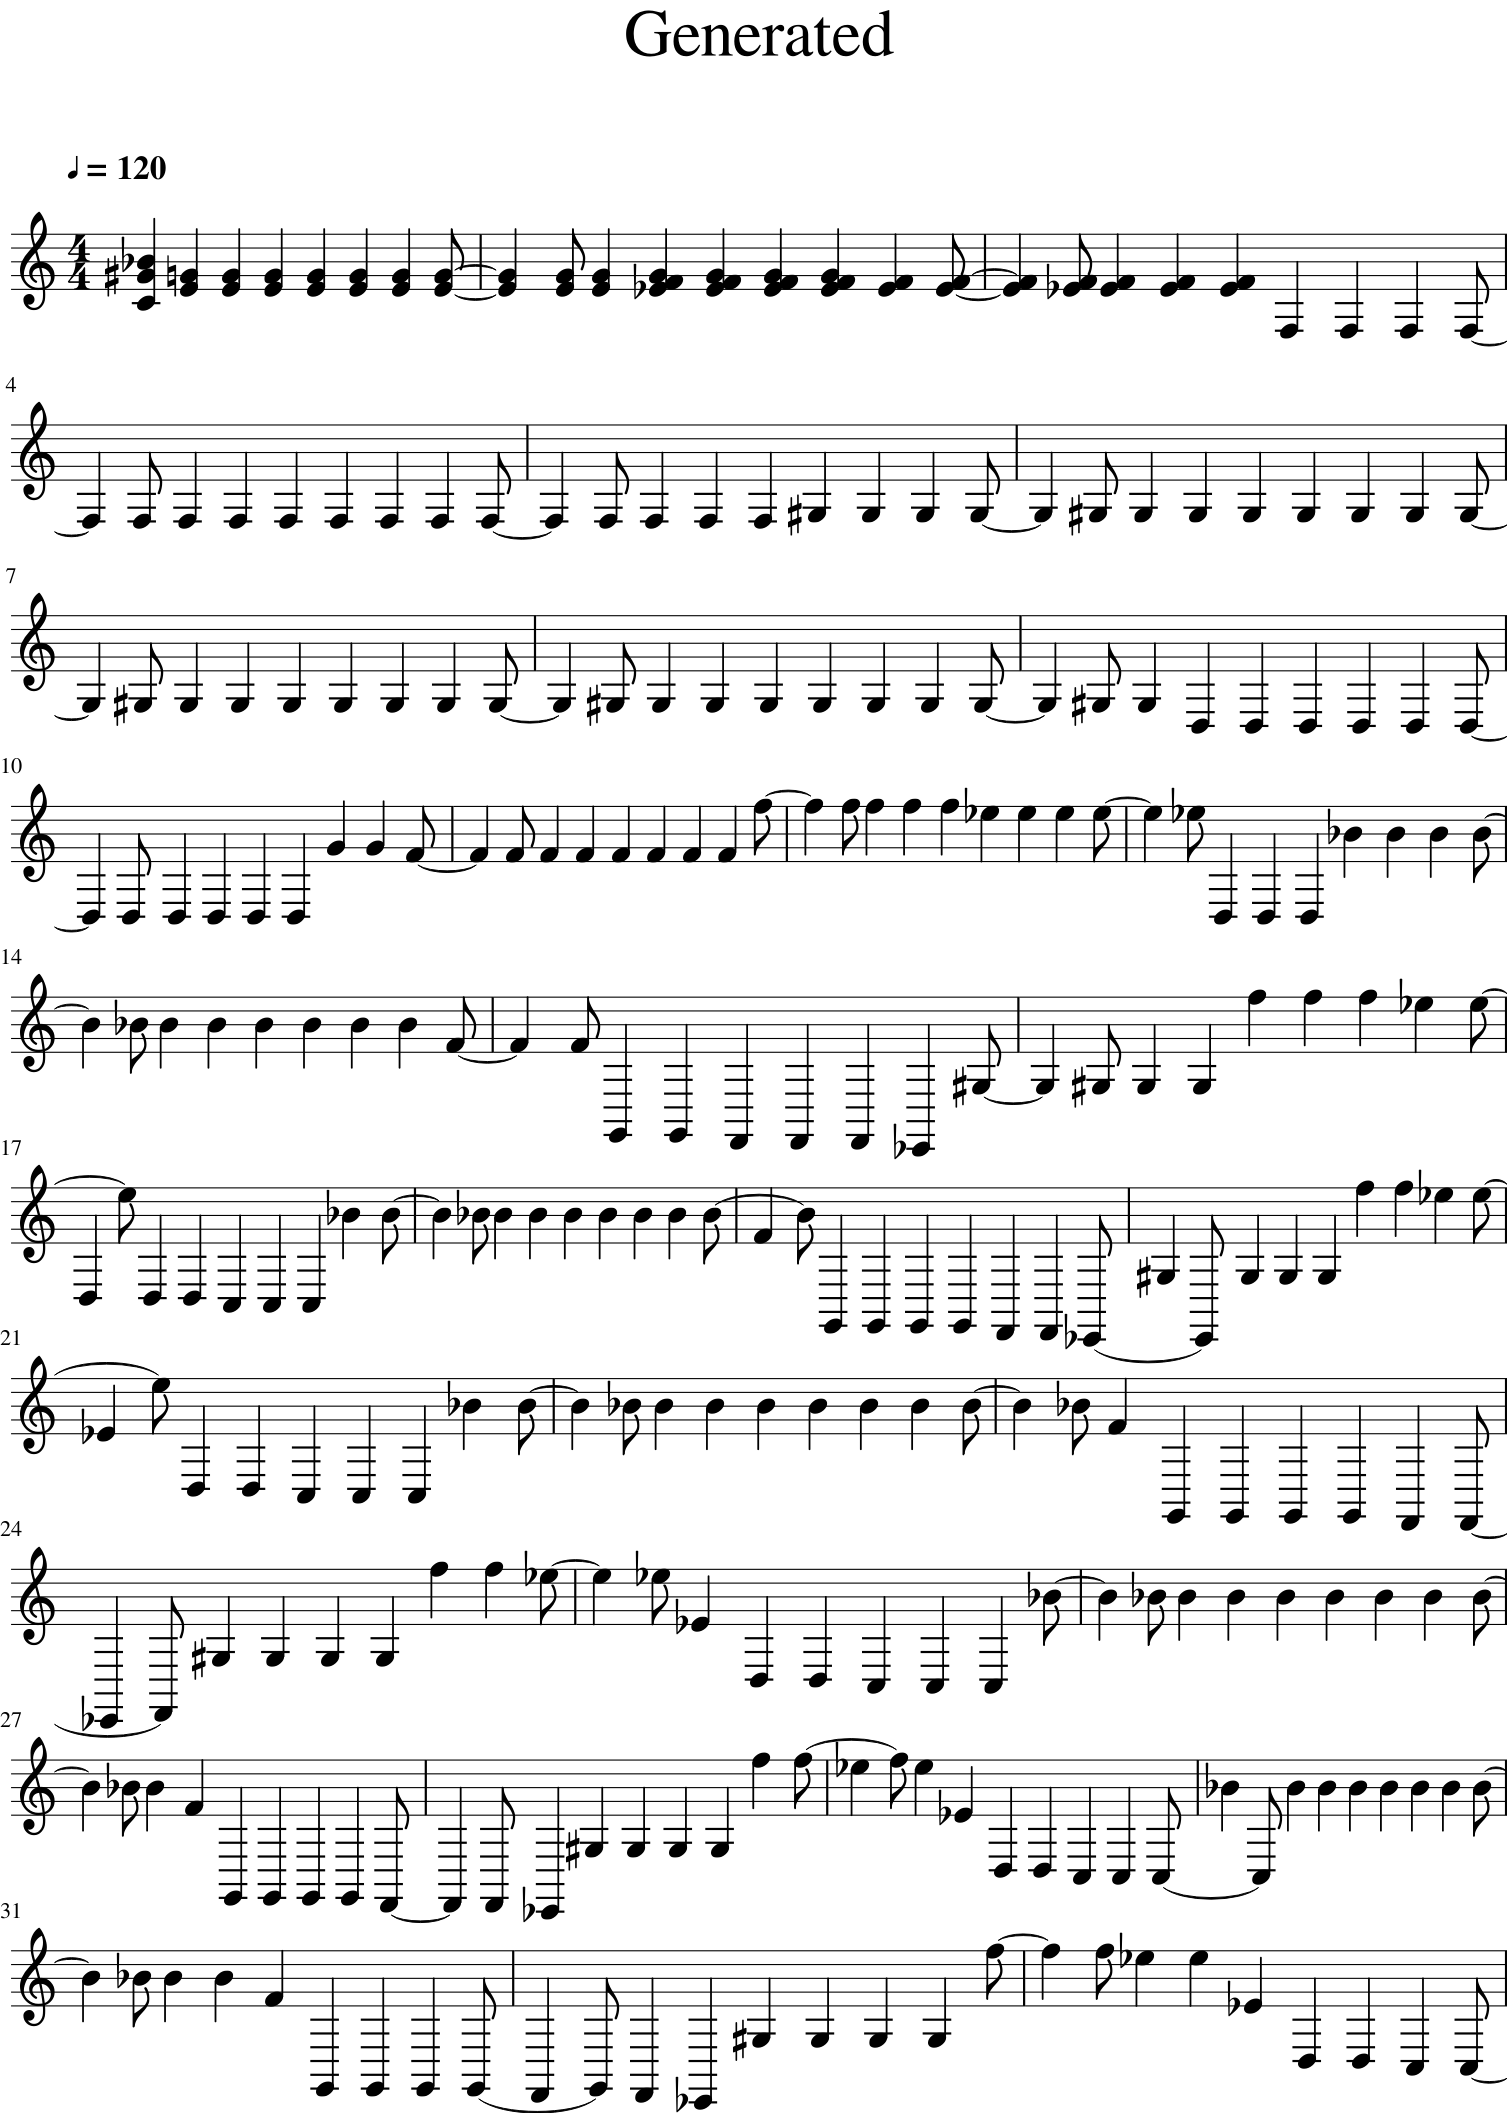

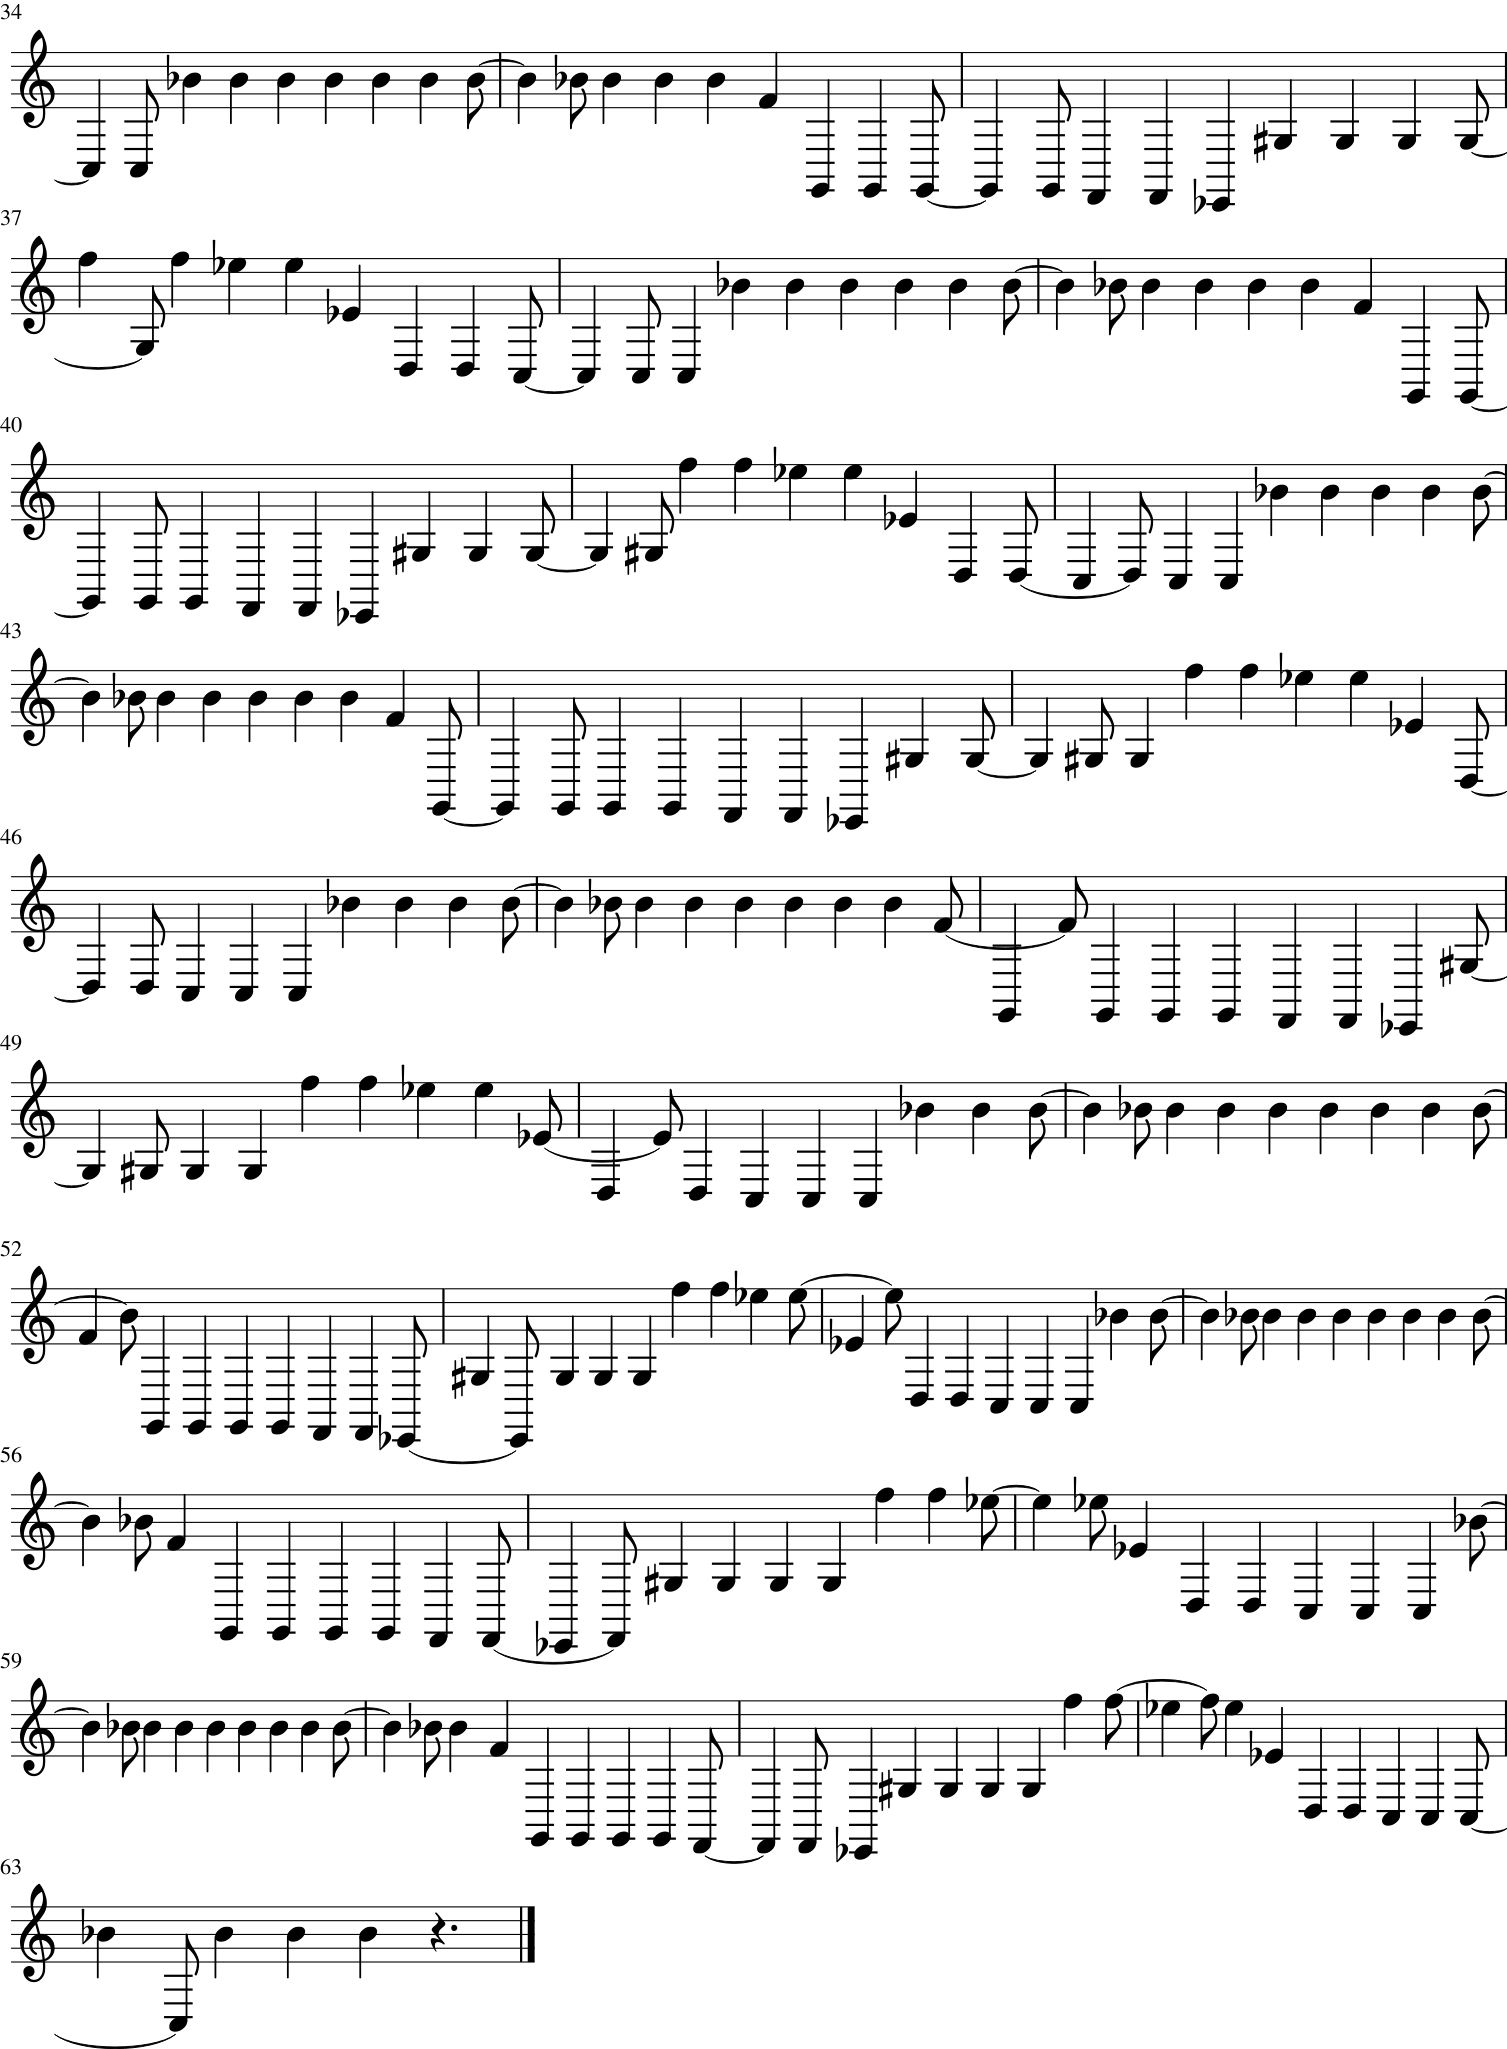

In [18]:
# Load the generated MIDI file
generated_midi = midi.MidiFile()
generated_midi.open('generated_song.mid')
generated_midi.read()
generated_midi.close()

# Convert MIDI file to stream for visualization
generated_stream = midi.translate.midiFileToStream(generated_midi)
generated_stream.metadata = metadata.Metadata()
generated_stream.metadata.title = 'Generated'

# Show the generated music sheet
generated_stream.show()
